In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap
from utils.utils import ClimateDownscalingLossJAX

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2024-10-27 15:47:01.801430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730062021.819993   25679 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730062021.825540   25679 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 15:47:04.677431: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


#### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the CMIP6 data to the GMFD resolution (e.g., ~25 km) to use as the target during training.

In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})


# Normalize the data (standardization)
def normalize(data):
    mean = data.mean().compute().item()
    std = data.std().compute().item()
    return (data - mean) / std

cmip6_data_norm = normalize(cmip6_high_res['tas'])
gmfd_data_norm = normalize(gmfd_data['tas'])

# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
gmfd_train = gmfd_data_norm.values

#### Split the data
Train set: The first portion of the time period (e.g., 60-70% of the time series).
Validation set: The next portion of the time series (e.g., the following 15-20% of the time series).
Test set: The final portion of the time series (e.g., the last 15-20%): 

In [3]:
# Reshape data to add the channel dimension
cmip6_train_reshaped = cmip6_train[..., np.newaxis]
gmfd_train_reshaped = gmfd_train[..., np.newaxis]

# Get the total number of time steps
n_samples = cmip6_train_reshaped.shape[0]

# Split indices based on time series order
train_size = int(n_samples * 0.6)  # 60% for training
val_size = int(n_samples * 0.2)    # 20% for validation
test_size = n_samples - train_size - val_size  # Remainder for test


# Split the data while preserving the temporal structure
X_train = cmip6_train_reshaped[:train_size]
y_train = gmfd_train_reshaped[:train_size]

X_val = cmip6_train_reshaped[train_size:train_size + val_size]
y_val = gmfd_train_reshaped[train_size:train_size + val_size]

X_test = cmip6_train_reshaped[train_size + val_size:]
y_test = gmfd_train_reshaped[train_size + val_size:]

#### Build the U-Net


In [5]:
def climate_unet(input_shape=(42, 97, 1), n_filters=64):
    """
  U-Net architecture for climate downscaling with:
    - Deeper architecture (5 encoder/decoder blocks)
    - Residual connections
    - Attention mechanisms
    - Advanced normalization
    """
    from tensorflow import keras
    from tensorflow.keras import layers
    
    inputs = keras.Input(shape=input_shape)
    
    # Initial processing
    x = layers.BatchNormalization()(inputs)
    
    # Encoder
    skip_connections = []
    
    def encoder_block(x, filters, dropout_rate=0.1):
        # First conv block
        conv = layers.Conv2D(filters, 3, activation='leaky_relu', padding='same')(x)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Conv2D(filters, 3, activation='leaky_relu', padding='same')(conv)
        conv = layers.BatchNormalization()(conv)
        
        # Residual connection
        res = layers.Conv2D(filters, 1, padding='same')(x)
        conv = layers.Add()([conv, res])
        
        # Attention mechanism
        attention = layers.Conv2D(filters, 1, activation='sigmoid')(conv)
        conv = layers.Multiply()([conv, attention])
        
        conv = layers.SpatialDropout2D(dropout_rate)(conv)
        pool = layers.MaxPooling2D(pool_size=(2, 2))(conv)
        
        return conv, pool
    
    # Encoder path
    conv1, pool1 = encoder_block(x, n_filters)
    conv2, pool2 = encoder_block(pool1, n_filters*2)
    conv3, pool3 = encoder_block(pool2, n_filters*4)
    conv4, pool4 = encoder_block(pool3, n_filters*8)
    
    # Middle block
    mid = layers.Conv2D(n_filters*16, 3, activation='leaky_relu', padding='same')(pool4)
    mid = layers.BatchNormalization()(mid)
    mid = layers.Conv2D(n_filters*16, 3, activation='leaky_relu', padding='same')(mid)
    mid = layers.BatchNormalization()(mid)
    mid = layers.SpatialDropout2D(0.3)(mid)
    
    def decoder_block(x, skip_connection, filters, dropout_rate=0.1):
        # Upsampling
        up = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        
        # Handle potential size mismatches
        padding_h = skip_connection.shape[1] - up.shape[1]
        padding_w = skip_connection.shape[2] - up.shape[2]
        if padding_h > 0 or padding_w > 0:
            up = layers.ZeroPadding2D(padding=((0, padding_h), (0, padding_w)))(up)
            
        # Concatenate skip connection
        concat = layers.concatenate([up, skip_connection])
        
        # Convolutional block
        conv = layers.Conv2D(filters, 3, activation='leaky_relu', padding='same')(concat)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Conv2D(filters, 3, activation='leaky_relu', padding='same')(conv)
        conv = layers.BatchNormalization()(conv)
        
        # Residual connection
        res = layers.Conv2D(filters, 1, padding='same')(concat)
        conv = layers.Add()([conv, res])
        
        # Channel attention
        avg_pool = layers.GlobalAveragePooling2D()(conv)
        avg_pool = layers.Reshape((1, 1, filters))(avg_pool)
        avg_pool = layers.Dense(filters // 4, activation='relu')(avg_pool)
        avg_pool = layers.Dense(filters, activation='sigmoid')(avg_pool)
        conv = layers.Multiply()([conv, avg_pool])
        
        conv = layers.SpatialDropout2D(dropout_rate)(conv)
        return conv
    
    # Decoder path with progressive upsampling
    up4 = decoder_block(mid, conv4, n_filters*8)
    up3 = decoder_block(up4, conv3, n_filters*4)
    up2 = decoder_block(up3, conv2, n_filters*2)
    up1 = decoder_block(up2, conv1, n_filters)
    
    # Final convolution blocks with residual connection
    final = layers.Conv2D(n_filters, 3, activation='leaky_relu', padding='same')(up1)
    final = layers.BatchNormalization()(final)
    final = layers.Conv2D(n_filters, 3, activation='leaky_relu', padding='same')(final)
    final = layers.BatchNormalization()(final)
    
    # Output layer with skip connection from input
    outputs = layers.Conv2D(1, 1, activation='linear', padding='same')(final)
    outputs = layers.Add()([outputs, inputs])  # Residual connection to input
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
input_shape = (42, 97, 1)
model = climate_unet(input_shape)

#### Train the model

In [6]:
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)
model = climate_unet(input_shape)
epochs = 1500

# Mixed Precision (if supported by your hardware)
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Learning rate schedule with warmup and cosine decay
initial_learning_rate = 1e-3
total_steps = int(np.ceil(len(X_train) / 32)) * epochs

lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps=total_steps//4,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-5
)

# Optimizer configuration
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)

# Initialize the custom loss function
climate_loss = ClimateDownscalingLossJAX()

# Compile model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Simplified callbacks
callbacks = [
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    
    # Learning rate monitoring
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Model checkpointing
    keras.callbacks.ModelCheckpoint(
        'models/unet_best_model.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=1
    ),
    
    # Terminate on NaN
    keras.callbacks.TerminateOnNaN()
]

# Training settings
epochs = 1500
batch_size = 64

# Calculate total batches
total_batches = int(np.ceil(len(X_train) / batch_size) * epochs)

# Initialize history
history = {
    'loss': [],
    'val_loss': [],
    'mean_absolute_error': [],
    'val_mean_absolute_error': [],
    'root_mean_squared_error': [],
    'val_root_mean_squared_error': [],
    'learning_rate': []
}

# Training loop
with tqdm(total=total_batches, desc='Training', unit='batch') as pbar:
    for epoch in range(epochs):
        # Training epoch
        history_epoch = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=1,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )
        
        # Update history
        for key in history_epoch.history:
            history[key].append(history_epoch.history[key][0])
        
        # Get current learning rate
        current_lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate))
        history['learning_rate'].append(current_lr)

        # Update progress bar
        pbar.set_postfix({
            'epoch': epoch + 1,
            'loss': f"{history['loss'][-1]:.4f}",
            'val_loss': f"{history['val_loss'][-1]:.4f}",
            'mae': f"{history['mean_absolute_error'][-1]:.4f}",
            'lr': f"{current_lr:.2e}"
})
        
        # Update progress
        pbar.update(int(np.ceil(len(X_train) / batch_size)))
        
        # Early stopping check
        if len(history['val_loss']) > 20:
            best_loss = min(history['val_loss'][:-20])
            recent_best = min(history['val_loss'][-20:])
            if recent_best >= best_loss and current_lr <= 1e-5:
                print("\nEarly stopping triggered: No improvement in validation loss")
                break

# # Save final model and history
# model.save_weights('models/unet_final_model.keras')
# np.save('models/training_history.npy', history)

print("\nTraining completed. Final metrics:")
for key in history:
    if key != 'learning_rate':
        print(f"{key}: {history[key][-1]:.4f}")
print(f"Best validation loss: {min(history['val_loss']):.4f}")

Training:   0%|                                                                                     | 0/669000 [00:00<?, ?batch/s]


Epoch 1: val_loss improved from inf to 0.16960, saving model to models/unet_best_model.weights.h5


Training:   0%|        | 446/669000 [02:16<56:56:08,  3.26batch/s, epoch=1, loss=0.1920, val_loss=0.1696, mae=0.4249, lr=1.00e-03]


Epoch 1: val_loss improved from 0.16960 to 0.14418, saving model to models/unet_best_model.weights.h5


Training:   0%|        | 892/669000 [02:46<30:39:52,  6.05batch/s, epoch=2, loss=0.1350, val_loss=0.1442, mae=0.3792, lr=1.00e-03]


Epoch 1: val_loss improved from 0.14418 to 0.13303, saving model to models/unet_best_model.weights.h5


Training:   0%|       | 1338/669000 [03:01<19:31:38,  9.50batch/s, epoch=3, loss=0.1292, val_loss=0.1330, mae=0.3718, lr=1.00e-03]


Epoch 1: val_loss improved from 0.13303 to 0.13053, saving model to models/unet_best_model.weights.h5


Training:   0%|       | 1784/669000 [03:16<14:14:49, 13.01batch/s, epoch=4, loss=0.1243, val_loss=0.1305, mae=0.3656, lr=1.00e-03]


Epoch 1: val_loss improved from 0.13053 to 0.12914, saving model to models/unet_best_model.weights.h5


Training:   0%|       | 2230/669000 [03:31<11:20:48, 16.32batch/s, epoch=5, loss=0.1217, val_loss=0.1291, mae=0.3633, lr=1.00e-03]


Epoch 1: val_loss did not improve from 0.12914


Training:   0%|        | 2676/669000 [03:45<9:26:09, 19.62batch/s, epoch=6, loss=0.1197, val_loss=0.1366, mae=0.3603, lr=9.99e-04]


Epoch 1: val_loss improved from 0.12914 to 0.12870, saving model to models/unet_best_model.weights.h5


Training:   0%|        | 3122/669000 [04:10<8:21:27, 22.13batch/s, epoch=7, loss=0.1181, val_loss=0.1287, mae=0.3576, lr=9.99e-04]


Epoch 1: val_loss did not improve from 0.12870


Training:   1%|        | 3568/669000 [04:13<7:30:38, 24.61batch/s, epoch=8, loss=0.1171, val_loss=0.1362, mae=0.3580, lr=9.99e-04]


Epoch 1: val_loss did not improve from 0.12870


Training:   1%|        | 4014/669000 [04:40<6:56:21, 26.62batch/s, epoch=9, loss=0.1162, val_loss=0.1303, mae=0.3553, lr=9.99e-04]


Epoch 1: val_loss improved from 0.12870 to 0.12683, saving model to models/unet_best_model.weights.h5


Training:   1%|       | 4460/669000 [04:42<6:41:12, 27.61batch/s, epoch=10, loss=0.1152, val_loss=0.1268, mae=0.3540, lr=9.98e-04]


Epoch 1: val_loss did not improve from 0.12683


Training:   1%|       | 4906/669000 [04:56<6:22:41, 28.92batch/s, epoch=11, loss=0.1131, val_loss=0.1308, mae=0.3509, lr=9.98e-04]


Epoch 1: val_loss improved from 0.12683 to 0.12522, saving model to models/unet_best_model.weights.h5


Training:   1%|       | 5352/669000 [05:10<6:17:35, 29.29batch/s, epoch=12, loss=0.1124, val_loss=0.1252, mae=0.3503, lr=9.97e-04]


Epoch 1: val_loss did not improve from 0.12522


Training:   1%|       | 5798/669000 [05:24<6:05:55, 30.21batch/s, epoch=13, loss=0.1108, val_loss=0.1259, mae=0.3482, lr=9.97e-04]


Epoch 1: val_loss improved from 0.12522 to 0.12077, saving model to models/unet_best_model.weights.h5


Training:   1%|       | 6244/669000 [05:50<6:05:52, 30.19batch/s, epoch=14, loss=0.1102, val_loss=0.1208, mae=0.3470, lr=9.97e-04]


Epoch 1: val_loss did not improve from 0.12077


Training:   1%|       | 6690/669000 [05:53<5:57:49, 30.85batch/s, epoch=15, loss=0.1105, val_loss=0.1223, mae=0.3459, lr=9.96e-04]


Epoch 1: val_loss improved from 0.12077 to 0.11919, saving model to models/unet_best_model.weights.h5


Training:   1%|       | 7136/669000 [06:20<5:59:32, 30.68batch/s, epoch=16, loss=0.1089, val_loss=0.1192, mae=0.3443, lr=9.96e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   1%|       | 7582/669000 [06:21<5:52:44, 31.25batch/s, epoch=17, loss=0.1067, val_loss=0.1194, mae=0.3416, lr=9.95e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   1%|       | 8028/669000 [06:35<5:48:57, 31.57batch/s, epoch=18, loss=0.1055, val_loss=0.1194, mae=0.3390, lr=9.94e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   1%|       | 8474/669000 [07:00<5:44:42, 31.94batch/s, epoch=19, loss=0.1051, val_loss=0.1269, mae=0.3382, lr=9.94e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   1%|       | 8920/669000 [07:02<5:42:16, 32.14batch/s, epoch=20, loss=0.1020, val_loss=0.1431, mae=0.3329, lr=9.93e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   1%|       | 9366/669000 [07:16<5:40:26, 32.29batch/s, epoch=21, loss=0.1036, val_loss=0.1234, mae=0.3361, lr=9.92e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   1%|       | 9812/669000 [07:40<5:38:54, 32.42batch/s, epoch=22, loss=0.1003, val_loss=0.1204, mae=0.3295, lr=9.92e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|      | 10258/669000 [07:43<5:37:44, 32.51batch/s, epoch=23, loss=0.0981, val_loss=0.1263, mae=0.3269, lr=9.91e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|      | 10704/669000 [07:56<5:36:40, 32.59batch/s, epoch=24, loss=0.0981, val_loss=0.1244, mae=0.3264, lr=9.90e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|      | 11150/669000 [08:10<5:36:38, 32.57batch/s, epoch=25, loss=0.0952, val_loss=0.1254, mae=0.3216, lr=9.89e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|      | 11596/669000 [08:24<5:36:05, 32.60batch/s, epoch=26, loss=0.0935, val_loss=0.1490, mae=0.3188, lr=9.88e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|      | 12042/669000 [08:50<5:35:21, 32.65batch/s, epoch=27, loss=0.0930, val_loss=0.1256, mae=0.3179, lr=9.87e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|      | 12488/669000 [08:51<5:35:19, 32.63batch/s, epoch=28, loss=0.0887, val_loss=0.1501, mae=0.3107, lr=9.86e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|      | 12934/669000 [09:05<5:35:45, 32.57batch/s, epoch=29, loss=0.0886, val_loss=0.1279, mae=0.3097, lr=9.85e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|      | 13380/669000 [09:30<5:35:18, 32.59batch/s, epoch=30, loss=0.0859, val_loss=0.1218, mae=0.3052, lr=9.84e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|      | 13826/669000 [09:32<5:34:41, 32.63batch/s, epoch=31, loss=0.0831, val_loss=0.1351, mae=0.3002, lr=9.83e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|▏     | 14272/669000 [09:46<5:35:07, 32.56batch/s, epoch=32, loss=0.0819, val_loss=0.1251, mae=0.2976, lr=9.82e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|▏     | 14718/669000 [10:10<5:34:29, 32.60batch/s, epoch=33, loss=0.0792, val_loss=0.1422, mae=0.2929, lr=9.81e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|▏     | 15164/669000 [10:13<5:33:51, 32.64batch/s, epoch=34, loss=0.0781, val_loss=0.1286, mae=0.2896, lr=9.80e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|▏     | 15610/669000 [10:40<5:33:13, 32.68batch/s, epoch=35, loss=0.0749, val_loss=0.1317, mae=0.2840, lr=9.79e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|▏     | 16056/669000 [10:40<5:32:59, 32.68batch/s, epoch=36, loss=0.0744, val_loss=0.1320, mae=0.2826, lr=9.77e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   2%|▏     | 16502/669000 [10:54<5:32:25, 32.71batch/s, epoch=37, loss=0.0724, val_loss=0.1388, mae=0.2786, lr=9.76e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 16948/669000 [11:20<5:32:16, 32.71batch/s, epoch=38, loss=0.0711, val_loss=0.1288, mae=0.2756, lr=9.75e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 17394/669000 [11:21<5:32:22, 32.67batch/s, epoch=39, loss=0.0705, val_loss=0.1296, mae=0.2738, lr=9.74e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 17840/669000 [11:35<5:31:35, 32.73batch/s, epoch=40, loss=0.0691, val_loss=0.1289, mae=0.2711, lr=9.72e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 18286/669000 [12:00<5:31:15, 32.74batch/s, epoch=41, loss=0.0674, val_loss=0.1324, mae=0.2672, lr=9.71e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 18732/669000 [12:02<5:31:31, 32.69batch/s, epoch=42, loss=0.0661, val_loss=0.1369, mae=0.2642, lr=9.69e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 19178/669000 [12:16<5:31:08, 32.71batch/s, epoch=43, loss=0.0636, val_loss=0.1333, mae=0.2588, lr=9.68e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 19624/669000 [12:40<5:30:44, 32.72batch/s, epoch=44, loss=0.0633, val_loss=0.1327, mae=0.2577, lr=9.66e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 20070/669000 [12:43<5:31:39, 32.61batch/s, epoch=45, loss=0.0604, val_loss=0.1292, mae=0.2509, lr=9.65e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 20516/669000 [13:10<5:30:53, 32.66batch/s, epoch=46, loss=0.0600, val_loss=0.1371, mae=0.2505, lr=9.63e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 20962/669000 [13:11<5:30:24, 32.69batch/s, epoch=47, loss=0.0584, val_loss=0.1277, mae=0.2461, lr=9.62e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 21408/669000 [13:24<5:30:12, 32.69batch/s, epoch=48, loss=0.0569, val_loss=0.1387, mae=0.2420, lr=9.60e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 21854/669000 [13:50<5:29:41, 32.71batch/s, epoch=49, loss=0.0560, val_loss=0.1379, mae=0.2393, lr=9.58e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 22300/669000 [13:51<5:29:21, 32.72batch/s, epoch=50, loss=0.0549, val_loss=0.1333, mae=0.2374, lr=9.57e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 22746/669000 [14:05<5:29:11, 32.72batch/s, epoch=51, loss=0.0547, val_loss=0.1347, mae=0.2361, lr=9.55e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   3%|▏     | 23192/669000 [14:30<5:30:14, 32.59batch/s, epoch=52, loss=0.0532, val_loss=0.1293, mae=0.2324, lr=9.53e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 23638/669000 [14:32<5:29:25, 32.65batch/s, epoch=53, loss=0.0511, val_loss=0.1322, mae=0.2265, lr=9.52e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 24084/669000 [14:46<5:28:48, 32.69batch/s, epoch=54, loss=0.0501, val_loss=0.1341, mae=0.2239, lr=9.50e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 24530/669000 [15:10<5:28:21, 32.71batch/s, epoch=55, loss=0.0498, val_loss=0.1363, mae=0.2230, lr=9.48e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 24976/669000 [15:13<5:27:52, 32.74batch/s, epoch=56, loss=0.0488, val_loss=0.1321, mae=0.2207, lr=9.46e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 25422/669000 [15:40<5:28:39, 32.64batch/s, epoch=57, loss=0.0478, val_loss=0.1399, mae=0.2171, lr=9.44e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 25868/669000 [15:41<5:28:21, 32.64batch/s, epoch=58, loss=0.0471, val_loss=0.1368, mae=0.2157, lr=9.42e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 26314/669000 [15:54<5:28:10, 32.64batch/s, epoch=59, loss=0.0469, val_loss=0.1286, mae=0.2145, lr=9.40e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 26760/669000 [16:20<5:28:42, 32.56batch/s, epoch=60, loss=0.0449, val_loss=0.1360, mae=0.2091, lr=9.38e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 27206/669000 [16:22<5:27:55, 32.62batch/s, epoch=61, loss=0.0444, val_loss=0.1318, mae=0.2075, lr=9.36e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▏     | 27652/669000 [16:35<5:27:40, 32.62batch/s, epoch=62, loss=0.0439, val_loss=0.1318, mae=0.2053, lr=9.34e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▎     | 28098/669000 [17:00<5:28:19, 32.53batch/s, epoch=63, loss=0.0428, val_loss=0.1305, mae=0.2023, lr=9.32e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▎     | 28544/669000 [17:03<5:27:44, 32.57batch/s, epoch=64, loss=0.0430, val_loss=0.1370, mae=0.2028, lr=9.30e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▎     | 28990/669000 [17:17<5:27:35, 32.56batch/s, epoch=65, loss=0.0416, val_loss=0.1305, mae=0.1990, lr=9.28e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▎     | 29436/669000 [17:30<5:26:49, 32.61batch/s, epoch=66, loss=0.0406, val_loss=0.1309, mae=0.1956, lr=9.25e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   4%|▎     | 29882/669000 [17:44<5:26:13, 32.65batch/s, epoch=67, loss=0.0405, val_loss=0.1360, mae=0.1960, lr=9.23e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 30328/669000 [18:10<5:25:42, 32.68batch/s, epoch=68, loss=0.0408, val_loss=0.1337, mae=0.1964, lr=9.21e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 30774/669000 [18:11<5:26:19, 32.60batch/s, epoch=69, loss=0.0389, val_loss=0.1276, mae=0.1903, lr=9.19e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 31220/669000 [18:25<5:26:00, 32.61batch/s, epoch=70, loss=0.0384, val_loss=0.1295, mae=0.1881, lr=9.16e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 31666/669000 [18:50<5:25:47, 32.60batch/s, epoch=71, loss=0.0381, val_loss=0.1304, mae=0.1881, lr=9.14e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 32112/669000 [18:52<5:26:07, 32.55batch/s, epoch=72, loss=0.0378, val_loss=0.1366, mae=0.1866, lr=9.12e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 32558/669000 [19:06<5:25:24, 32.60batch/s, epoch=73, loss=0.0367, val_loss=0.1333, mae=0.1827, lr=9.09e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 33004/669000 [19:30<5:25:02, 32.61batch/s, epoch=74, loss=0.0364, val_loss=0.1315, mae=0.1821, lr=9.07e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 33450/669000 [19:33<5:24:28, 32.64batch/s, epoch=75, loss=0.0358, val_loss=0.1361, mae=0.1795, lr=9.05e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 33896/669000 [20:00<5:23:50, 32.69batch/s, epoch=76, loss=0.0359, val_loss=0.1337, mae=0.1803, lr=9.02e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 34342/669000 [20:01<5:23:44, 32.67batch/s, epoch=77, loss=0.0350, val_loss=0.1405, mae=0.1772, lr=9.00e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 34788/669000 [20:14<5:24:04, 32.62batch/s, epoch=78, loss=0.0339, val_loss=0.1413, mae=0.1733, lr=8.97e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 35234/669000 [20:40<5:23:27, 32.66batch/s, epoch=79, loss=0.0343, val_loss=0.1390, mae=0.1749, lr=8.94e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 35680/669000 [20:42<5:24:22, 32.54batch/s, epoch=80, loss=0.0334, val_loss=0.1336, mae=0.1718, lr=8.92e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 36126/669000 [20:56<5:24:57, 32.46batch/s, epoch=81, loss=0.0329, val_loss=0.1312, mae=0.1701, lr=8.89e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   5%|▎     | 36572/669000 [21:20<5:24:11, 32.51batch/s, epoch=82, loss=0.0330, val_loss=0.1354, mae=0.1709, lr=8.87e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 37018/669000 [21:23<5:23:28, 32.56batch/s, epoch=83, loss=0.0324, val_loss=0.1302, mae=0.1685, lr=8.84e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 37464/669000 [21:50<5:27:30, 32.14batch/s, epoch=84, loss=0.0320, val_loss=0.1304, mae=0.1673, lr=8.81e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 37910/669000 [21:51<5:26:12, 32.24batch/s, epoch=85, loss=0.0317, val_loss=0.1311, mae=0.1662, lr=8.78e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 38356/669000 [22:04<5:24:25, 32.40batch/s, epoch=86, loss=0.0312, val_loss=0.1320, mae=0.1637, lr=8.76e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 38802/669000 [22:30<5:23:15, 32.49batch/s, epoch=87, loss=0.0307, val_loss=0.1312, mae=0.1621, lr=8.73e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 39248/669000 [22:32<5:22:31, 32.54batch/s, epoch=88, loss=0.0310, val_loss=0.1336, mae=0.1632, lr=8.70e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 39694/669000 [22:45<5:22:23, 32.53batch/s, epoch=89, loss=0.0306, val_loss=0.1396, mae=0.1618, lr=8.67e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 40140/669000 [23:10<5:21:48, 32.57batch/s, epoch=90, loss=0.0303, val_loss=0.1337, mae=0.1607, lr=8.64e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 40586/669000 [23:13<5:21:22, 32.59batch/s, epoch=91, loss=0.0292, val_loss=0.1394, mae=0.1568, lr=8.62e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 41032/669000 [23:27<5:21:32, 32.55batch/s, epoch=92, loss=0.0290, val_loss=0.1404, mae=0.1560, lr=8.59e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▎     | 41478/669000 [23:50<5:20:46, 32.60batch/s, epoch=93, loss=0.0291, val_loss=0.1328, mae=0.1562, lr=8.56e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▍     | 41924/669000 [23:54<5:20:05, 32.65batch/s, epoch=94, loss=0.0286, val_loss=0.1326, mae=0.1547, lr=8.53e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▍     | 42370/669000 [24:20<5:20:04, 32.63batch/s, epoch=95, loss=0.0282, val_loss=0.1320, mae=0.1541, lr=8.50e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▍     | 42816/669000 [24:21<5:20:03, 32.61batch/s, epoch=96, loss=0.0281, val_loss=0.1339, mae=0.1528, lr=8.47e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   6%|▍     | 43262/669000 [24:35<5:19:26, 32.65batch/s, epoch=97, loss=0.0274, val_loss=0.1358, mae=0.1496, lr=8.44e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▍     | 43708/669000 [25:00<5:19:31, 32.62batch/s, epoch=98, loss=0.0272, val_loss=0.1381, mae=0.1490, lr=8.41e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▍     | 44154/669000 [25:02<5:18:46, 32.67batch/s, epoch=99, loss=0.0276, val_loss=0.1337, mae=0.1512, lr=8.38e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 44600/669000 [25:16<5:18:26, 32.68batch/s, epoch=100, loss=0.0273, val_loss=0.1424, mae=0.1494, lr=8.35e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 45046/669000 [25:40<5:18:02, 32.70batch/s, epoch=101, loss=0.0270, val_loss=0.1316, mae=0.1492, lr=8.31e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 45492/669000 [25:43<5:17:58, 32.68batch/s, epoch=102, loss=0.0270, val_loss=0.1381, mae=0.1467, lr=8.28e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 45938/669000 [25:57<5:17:34, 32.70batch/s, epoch=103, loss=0.0267, val_loss=0.1324, mae=0.1471, lr=8.25e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 46384/669000 [26:10<5:17:10, 32.72batch/s, epoch=104, loss=0.0259, val_loss=0.1373, mae=0.1445, lr=8.22e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 46830/669000 [26:24<5:17:39, 32.64batch/s, epoch=105, loss=0.0261, val_loss=0.1348, mae=0.1450, lr=8.19e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 47276/669000 [26:50<5:16:57, 32.69batch/s, epoch=106, loss=0.0257, val_loss=0.1341, mae=0.1435, lr=8.15e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 47722/669000 [26:51<5:16:30, 32.72batch/s, epoch=107, loss=0.0251, val_loss=0.1299, mae=0.1409, lr=8.12e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 48168/669000 [27:05<5:16:21, 32.71batch/s, epoch=108, loss=0.0252, val_loss=0.1327, mae=0.1417, lr=8.09e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 48614/669000 [27:30<5:16:26, 32.68batch/s, epoch=109, loss=0.0249, val_loss=0.1364, mae=0.1402, lr=8.06e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 49060/669000 [27:32<5:16:07, 32.68batch/s, epoch=110, loss=0.0250, val_loss=0.1342, mae=0.1411, lr=8.02e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 49506/669000 [27:46<5:16:14, 32.65batch/s, epoch=111, loss=0.0244, val_loss=0.1306, mae=0.1387, lr=7.99e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   7%|▎    | 49952/669000 [28:10<5:15:52, 32.66batch/s, epoch=112, loss=0.0247, val_loss=0.1324, mae=0.1401, lr=7.96e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 50398/669000 [28:13<5:15:36, 32.67batch/s, epoch=113, loss=0.0246, val_loss=0.1365, mae=0.1395, lr=7.92e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 50844/669000 [28:27<5:15:19, 32.67batch/s, epoch=114, loss=0.0242, val_loss=0.1348, mae=0.1372, lr=7.89e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 51290/669000 [28:41<5:16:15, 32.55batch/s, epoch=115, loss=0.0241, val_loss=0.1316, mae=0.1381, lr=7.85e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 51736/669000 [28:54<5:15:27, 32.61batch/s, epoch=116, loss=0.0236, val_loss=0.1343, mae=0.1352, lr=7.82e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 52182/669000 [29:20<5:15:05, 32.63batch/s, epoch=117, loss=0.0232, val_loss=0.1317, mae=0.1337, lr=7.78e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 52628/669000 [29:21<5:14:32, 32.66batch/s, epoch=118, loss=0.0235, val_loss=0.1341, mae=0.1351, lr=7.75e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 53074/669000 [29:35<5:14:48, 32.61batch/s, epoch=119, loss=0.0231, val_loss=0.1360, mae=0.1331, lr=7.71e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 53520/669000 [30:00<5:14:48, 32.59batch/s, epoch=120, loss=0.0229, val_loss=0.1319, mae=0.1326, lr=7.68e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 53966/669000 [30:03<5:15:09, 32.52batch/s, epoch=121, loss=0.0236, val_loss=0.1337, mae=0.1352, lr=7.64e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 54412/669000 [30:17<5:15:39, 32.45batch/s, epoch=122, loss=0.0229, val_loss=0.1340, mae=0.1327, lr=7.61e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 54858/669000 [30:40<5:14:47, 32.52batch/s, epoch=123, loss=0.0221, val_loss=0.1311, mae=0.1294, lr=7.57e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 55304/669000 [30:44<5:14:19, 32.54batch/s, epoch=124, loss=0.0222, val_loss=0.1340, mae=0.1298, lr=7.54e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 55750/669000 [31:10<5:13:31, 32.60batch/s, epoch=125, loss=0.0224, val_loss=0.1320, mae=0.1306, lr=7.50e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 56196/669000 [31:11<5:12:58, 32.63batch/s, epoch=126, loss=0.0219, val_loss=0.1310, mae=0.1290, lr=7.46e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   8%|▍    | 56642/669000 [31:25<5:13:19, 32.57batch/s, epoch=127, loss=0.0216, val_loss=0.1333, mae=0.1269, lr=7.43e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 57088/669000 [31:50<5:13:25, 32.54batch/s, epoch=128, loss=0.0222, val_loss=0.1322, mae=0.1302, lr=7.39e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 57534/669000 [31:52<5:12:33, 32.60batch/s, epoch=129, loss=0.0217, val_loss=0.1347, mae=0.1282, lr=7.35e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 57980/669000 [32:06<5:12:12, 32.62batch/s, epoch=130, loss=0.0211, val_loss=0.1327, mae=0.1256, lr=7.32e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 58426/669000 [32:30<5:11:45, 32.64batch/s, epoch=131, loss=0.0208, val_loss=0.1292, mae=0.1243, lr=7.28e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 58872/669000 [32:33<5:11:24, 32.65batch/s, epoch=132, loss=0.0212, val_loss=0.1344, mae=0.1262, lr=7.24e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 59318/669000 [33:00<5:11:52, 32.58batch/s, epoch=133, loss=0.0213, val_loss=0.1372, mae=0.1266, lr=7.20e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 59764/669000 [33:01<5:11:23, 32.61batch/s, epoch=134, loss=0.0213, val_loss=0.1312, mae=0.1268, lr=7.17e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 60210/669000 [33:14<5:10:52, 32.64batch/s, epoch=135, loss=0.0206, val_loss=0.1304, mae=0.1235, lr=7.13e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 60656/669000 [33:40<5:11:38, 32.53batch/s, epoch=136, loss=0.0204, val_loss=0.1291, mae=0.1219, lr=7.09e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 61102/669000 [33:42<5:11:21, 32.54batch/s, epoch=137, loss=0.0202, val_loss=0.1332, mae=0.1224, lr=7.05e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 61548/669000 [33:55<5:10:49, 32.57batch/s, epoch=138, loss=0.0205, val_loss=0.1285, mae=0.1241, lr=7.01e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 61994/669000 [34:20<5:10:19, 32.60batch/s, epoch=139, loss=0.0200, val_loss=0.1317, mae=0.1201, lr=6.98e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 62440/669000 [34:23<5:10:23, 32.57batch/s, epoch=140, loss=0.0201, val_loss=0.1312, mae=0.1210, lr=6.94e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 62886/669000 [34:36<5:10:06, 32.57batch/s, epoch=141, loss=0.0200, val_loss=0.1339, mae=0.1210, lr=6.90e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:   9%|▍    | 63332/669000 [35:00<5:09:57, 32.57batch/s, epoch=142, loss=0.0198, val_loss=0.1314, mae=0.1198, lr=6.86e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▍    | 63778/669000 [35:04<5:09:51, 32.55batch/s, epoch=143, loss=0.0198, val_loss=0.1315, mae=0.1197, lr=6.82e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▍    | 64224/669000 [35:30<5:09:18, 32.59batch/s, epoch=144, loss=0.0194, val_loss=0.1337, mae=0.1185, lr=6.78e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▍    | 64670/669000 [35:31<5:08:53, 32.61batch/s, epoch=145, loss=0.0197, val_loss=0.1281, mae=0.1200, lr=6.74e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▍    | 65116/669000 [35:45<5:08:27, 32.63batch/s, epoch=146, loss=0.0195, val_loss=0.1316, mae=0.1189, lr=6.70e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▍    | 65562/669000 [36:10<5:08:17, 32.62batch/s, epoch=147, loss=0.0194, val_loss=0.1295, mae=0.1185, lr=6.66e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▍    | 66008/669000 [36:12<5:08:01, 32.63batch/s, epoch=148, loss=0.0192, val_loss=0.1312, mae=0.1176, lr=6.62e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▍    | 66454/669000 [36:26<5:07:42, 32.64batch/s, epoch=149, loss=0.0194, val_loss=0.1355, mae=0.1188, lr=6.58e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▌    | 66900/669000 [36:50<5:07:21, 32.65batch/s, epoch=150, loss=0.0189, val_loss=0.1314, mae=0.1157, lr=6.55e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▌    | 67346/669000 [36:53<5:07:10, 32.64batch/s, epoch=151, loss=0.0187, val_loss=0.1297, mae=0.1148, lr=6.51e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▌    | 67792/669000 [37:20<5:07:13, 32.62batch/s, epoch=152, loss=0.0186, val_loss=0.1314, mae=0.1146, lr=6.47e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▌    | 68238/669000 [37:21<5:08:11, 32.49batch/s, epoch=153, loss=0.0187, val_loss=0.1319, mae=0.1153, lr=6.43e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▌    | 68684/669000 [37:34<5:07:40, 32.52batch/s, epoch=154, loss=0.0188, val_loss=0.1305, mae=0.1162, lr=6.38e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▌    | 69130/669000 [38:00<5:07:22, 32.53batch/s, epoch=155, loss=0.0184, val_loss=0.1309, mae=0.1134, lr=6.34e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▌    | 69576/669000 [38:02<5:06:42, 32.57batch/s, epoch=156, loss=0.0183, val_loss=0.1304, mae=0.1134, lr=6.30e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  10%|▌    | 70022/669000 [38:16<5:07:28, 32.47batch/s, epoch=157, loss=0.0188, val_loss=0.1303, mae=0.1165, lr=6.26e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 70468/669000 [38:40<5:07:36, 32.43batch/s, epoch=158, loss=0.0187, val_loss=0.1300, mae=0.1166, lr=6.22e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 70914/669000 [38:43<5:07:09, 32.45batch/s, epoch=159, loss=0.0182, val_loss=0.1347, mae=0.1139, lr=6.18e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 71360/669000 [39:10<5:07:37, 32.38batch/s, epoch=160, loss=0.0184, val_loss=0.1282, mae=0.1150, lr=6.14e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 71806/669000 [39:11<5:07:01, 32.42batch/s, epoch=161, loss=0.0176, val_loss=0.1290, mae=0.1100, lr=6.10e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 72252/669000 [39:24<5:07:00, 32.40batch/s, epoch=162, loss=0.0178, val_loss=0.1314, mae=0.1111, lr=6.06e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 72698/669000 [39:50<5:05:40, 32.51batch/s, epoch=163, loss=0.0176, val_loss=0.1309, mae=0.1107, lr=6.02e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 73144/669000 [39:52<5:04:45, 32.59batch/s, epoch=164, loss=0.0179, val_loss=0.1305, mae=0.1129, lr=5.98e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 73590/669000 [40:05<5:04:19, 32.61batch/s, epoch=165, loss=0.0176, val_loss=0.1319, mae=0.1105, lr=5.94e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 74036/669000 [40:30<5:03:36, 32.66batch/s, epoch=166, loss=0.0177, val_loss=0.1294, mae=0.1116, lr=5.90e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 74482/669000 [40:33<5:03:03, 32.70batch/s, epoch=167, loss=0.0175, val_loss=0.1316, mae=0.1110, lr=5.85e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 74928/669000 [40:46<5:02:43, 32.71batch/s, epoch=168, loss=0.0171, val_loss=0.1284, mae=0.1079, lr=5.81e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 75374/669000 [41:10<5:03:21, 32.61batch/s, epoch=169, loss=0.0172, val_loss=0.1291, mae=0.1086, lr=5.77e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 75820/669000 [41:13<5:02:36, 32.67batch/s, epoch=170, loss=0.0171, val_loss=0.1295, mae=0.1079, lr=5.73e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 76266/669000 [41:40<5:02:22, 32.67batch/s, epoch=171, loss=0.0172, val_loss=0.1326, mae=0.1087, lr=5.69e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  11%|▌    | 76712/669000 [41:41<5:02:00, 32.69batch/s, epoch=172, loss=0.0169, val_loss=0.1300, mae=0.1071, lr=5.65e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 77158/669000 [41:55<5:02:24, 32.62batch/s, epoch=173, loss=0.0168, val_loss=0.1297, mae=0.1070, lr=5.61e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 77604/669000 [42:20<5:01:51, 32.65batch/s, epoch=174, loss=0.0169, val_loss=0.1283, mae=0.1079, lr=5.56e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 78050/669000 [42:22<5:01:54, 32.62batch/s, epoch=175, loss=0.0167, val_loss=0.1284, mae=0.1070, lr=5.52e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 78496/669000 [42:35<5:01:20, 32.66batch/s, epoch=176, loss=0.0167, val_loss=0.1277, mae=0.1070, lr=5.48e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 78942/669000 [43:00<5:00:55, 32.68batch/s, epoch=177, loss=0.0168, val_loss=0.1304, mae=0.1074, lr=5.44e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 79388/669000 [43:03<5:00:46, 32.67batch/s, epoch=178, loss=0.0168, val_loss=0.1315, mae=0.1079, lr=5.40e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 79834/669000 [43:17<5:01:25, 32.58batch/s, epoch=179, loss=0.0166, val_loss=0.1279, mae=0.1066, lr=5.36e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 80280/669000 [43:40<5:00:49, 32.62batch/s, epoch=180, loss=0.0165, val_loss=0.1304, mae=0.1053, lr=5.31e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 80726/669000 [43:44<5:00:22, 32.64batch/s, epoch=181, loss=0.0165, val_loss=0.1319, mae=0.1058, lr=5.27e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 81172/669000 [44:10<4:59:56, 32.66batch/s, epoch=182, loss=0.0163, val_loss=0.1290, mae=0.1045, lr=5.23e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 81618/669000 [44:11<4:59:25, 32.69batch/s, epoch=183, loss=0.0163, val_loss=0.1293, mae=0.1055, lr=5.19e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 82064/669000 [44:25<4:59:15, 32.69batch/s, epoch=184, loss=0.0158, val_loss=0.1307, mae=0.1021, lr=5.15e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 82510/669000 [44:50<4:59:13, 32.67batch/s, epoch=185, loss=0.0164, val_loss=0.1296, mae=0.1059, lr=5.10e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 82956/669000 [44:52<4:59:36, 32.60batch/s, epoch=186, loss=0.0161, val_loss=0.1296, mae=0.1039, lr=5.06e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  12%|▌    | 83402/669000 [45:06<4:58:58, 32.65batch/s, epoch=187, loss=0.0158, val_loss=0.1284, mae=0.1024, lr=5.02e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 83848/669000 [45:30<4:58:38, 32.66batch/s, epoch=188, loss=0.0161, val_loss=0.1277, mae=0.1046, lr=4.98e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 84294/669000 [45:33<4:58:23, 32.66batch/s, epoch=189, loss=0.0160, val_loss=0.1305, mae=0.1035, lr=4.94e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 84740/669000 [45:47<4:58:13, 32.65batch/s, epoch=190, loss=0.0159, val_loss=0.1275, mae=0.1038, lr=4.90e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 85186/669000 [46:00<4:57:46, 32.68batch/s, epoch=191, loss=0.0156, val_loss=0.1277, mae=0.1012, lr=4.85e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 85632/669000 [46:14<4:57:23, 32.69batch/s, epoch=192, loss=0.0155, val_loss=0.1298, mae=0.1009, lr=4.81e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 86078/669000 [46:40<4:57:11, 32.69batch/s, epoch=193, loss=0.0159, val_loss=0.1302, mae=0.1048, lr=4.77e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 86524/669000 [46:41<4:56:53, 32.70batch/s, epoch=194, loss=0.0155, val_loss=0.1318, mae=0.1016, lr=4.73e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 86970/669000 [46:55<4:56:37, 32.70batch/s, epoch=195, loss=0.0155, val_loss=0.1272, mae=0.1021, lr=4.69e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 87416/669000 [47:20<4:56:24, 32.70batch/s, epoch=196, loss=0.0154, val_loss=0.1309, mae=0.1014, lr=4.64e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 87862/669000 [47:22<4:57:17, 32.58batch/s, epoch=197, loss=0.0151, val_loss=0.1299, mae=0.0993, lr=4.60e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 88308/669000 [47:36<4:56:46, 32.61batch/s, epoch=198, loss=0.0152, val_loss=0.1291, mae=0.1001, lr=4.56e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 88754/669000 [48:00<4:56:35, 32.61batch/s, epoch=199, loss=0.0150, val_loss=0.1278, mae=0.0986, lr=4.52e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 89200/669000 [48:03<4:56:20, 32.61batch/s, epoch=200, loss=0.0154, val_loss=0.1319, mae=0.1020, lr=4.48e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 89646/669000 [48:17<4:55:39, 32.66batch/s, epoch=201, loss=0.0154, val_loss=0.1280, mae=0.1017, lr=4.44e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  13%|▋    | 90092/669000 [48:31<4:55:17, 32.67batch/s, epoch=202, loss=0.0151, val_loss=0.1294, mae=0.0996, lr=4.39e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 90538/669000 [48:44<4:54:55, 32.69batch/s, epoch=203, loss=0.0148, val_loss=0.1290, mae=0.0982, lr=4.35e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 90984/669000 [49:10<4:54:51, 32.67batch/s, epoch=204, loss=0.0149, val_loss=0.1311, mae=0.0990, lr=4.31e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 91430/669000 [49:11<4:54:24, 32.70batch/s, epoch=205, loss=0.0146, val_loss=0.1272, mae=0.0968, lr=4.27e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 91876/669000 [49:25<4:54:58, 32.61batch/s, epoch=206, loss=0.0149, val_loss=0.1305, mae=0.0994, lr=4.23e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 92322/669000 [49:50<4:54:38, 32.62batch/s, epoch=207, loss=0.0146, val_loss=0.1294, mae=0.0969, lr=4.19e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 92768/669000 [49:53<4:54:10, 32.65batch/s, epoch=208, loss=0.0149, val_loss=0.1272, mae=0.0992, lr=4.15e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 93214/669000 [50:06<4:54:51, 32.55batch/s, epoch=209, loss=0.0146, val_loss=0.1304, mae=0.0973, lr=4.10e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 93660/669000 [50:30<4:54:26, 32.57batch/s, epoch=210, loss=0.0146, val_loss=0.1293, mae=0.0972, lr=4.06e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 94106/669000 [50:34<4:53:57, 32.59batch/s, epoch=211, loss=0.0148, val_loss=0.1284, mae=0.0988, lr=4.02e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 94552/669000 [51:00<4:54:15, 32.54batch/s, epoch=212, loss=0.0147, val_loss=0.1295, mae=0.0989, lr=3.98e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 94998/669000 [51:01<4:53:43, 32.57batch/s, epoch=213, loss=0.0144, val_loss=0.1286, mae=0.0962, lr=3.94e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 95444/669000 [51:15<4:53:22, 32.58batch/s, epoch=214, loss=0.0144, val_loss=0.1312, mae=0.0959, lr=3.90e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 95890/669000 [51:40<4:53:22, 32.56batch/s, epoch=215, loss=0.0143, val_loss=0.1296, mae=0.0967, lr=3.86e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 96336/669000 [51:42<4:53:03, 32.57batch/s, epoch=216, loss=0.0141, val_loss=0.1298, mae=0.0940, lr=3.82e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  14%|▋    | 96782/669000 [51:56<4:52:43, 32.58batch/s, epoch=217, loss=0.0144, val_loss=0.1298, mae=0.0973, lr=3.78e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▋    | 97228/669000 [52:20<4:52:45, 32.55batch/s, epoch=218, loss=0.0139, val_loss=0.1290, mae=0.0931, lr=3.74e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▋    | 97674/669000 [52:23<4:52:16, 32.58batch/s, epoch=219, loss=0.0140, val_loss=0.1283, mae=0.0941, lr=3.70e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▋    | 98120/669000 [52:37<4:51:54, 32.59batch/s, epoch=220, loss=0.0141, val_loss=0.1314, mae=0.0948, lr=3.66e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▋    | 98566/669000 [52:51<4:52:01, 32.56batch/s, epoch=221, loss=0.0145, val_loss=0.1295, mae=0.0979, lr=3.62e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▋    | 99012/669000 [53:04<4:51:32, 32.58batch/s, epoch=222, loss=0.0141, val_loss=0.1280, mae=0.0956, lr=3.57e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▋    | 99458/669000 [53:30<4:51:53, 32.52batch/s, epoch=223, loss=0.0140, val_loss=0.1277, mae=0.0946, lr=3.53e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▋    | 99904/669000 [53:32<4:51:17, 32.56batch/s, epoch=224, loss=0.0140, val_loss=0.1297, mae=0.0942, lr=3.49e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▌   | 100350/669000 [53:45<4:50:50, 32.59batch/s, epoch=225, loss=0.0139, val_loss=0.1291, mae=0.0945, lr=3.45e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▌   | 100796/669000 [54:10<4:50:27, 32.60batch/s, epoch=226, loss=0.0138, val_loss=0.1274, mae=0.0928, lr=3.42e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▌   | 101242/669000 [54:13<4:50:57, 32.52batch/s, epoch=227, loss=0.0138, val_loss=0.1293, mae=0.0940, lr=3.38e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▌   | 101688/669000 [54:27<4:50:26, 32.55batch/s, epoch=228, loss=0.0136, val_loss=0.1280, mae=0.0925, lr=3.34e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▌   | 102134/669000 [54:50<4:50:00, 32.58batch/s, epoch=229, loss=0.0137, val_loss=0.1282, mae=0.0935, lr=3.30e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▌   | 102580/669000 [54:54<4:50:05, 32.54batch/s, epoch=230, loss=0.0137, val_loss=0.1288, mae=0.0928, lr=3.26e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▌   | 103026/669000 [55:20<4:50:30, 32.47batch/s, epoch=231, loss=0.0138, val_loss=0.1283, mae=0.0944, lr=3.22e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  15%|▌   | 103472/669000 [55:21<4:49:33, 32.55batch/s, epoch=232, loss=0.0137, val_loss=0.1268, mae=0.0929, lr=3.18e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▌   | 103918/669000 [55:35<4:49:19, 32.55batch/s, epoch=233, loss=0.0135, val_loss=0.1313, mae=0.0917, lr=3.14e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▌   | 104364/669000 [56:00<4:48:52, 32.58batch/s, epoch=234, loss=0.0134, val_loss=0.1273, mae=0.0918, lr=3.10e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 104810/669000 [56:02<4:48:24, 32.60batch/s, epoch=235, loss=0.0134, val_loss=0.1277, mae=0.0916, lr=3.06e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 105256/669000 [56:16<4:48:42, 32.54batch/s, epoch=236, loss=0.0134, val_loss=0.1294, mae=0.0915, lr=3.02e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 105702/669000 [56:40<4:48:24, 32.55batch/s, epoch=237, loss=0.0133, val_loss=0.1281, mae=0.0908, lr=2.99e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 106148/669000 [56:43<4:47:52, 32.59batch/s, epoch=238, loss=0.0131, val_loss=0.1286, mae=0.0900, lr=2.95e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 106594/669000 [57:10<4:48:14, 32.52batch/s, epoch=239, loss=0.0134, val_loss=0.1278, mae=0.0919, lr=2.91e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 107040/669000 [57:11<4:48:45, 32.44batch/s, epoch=240, loss=0.0134, val_loss=0.1276, mae=0.0924, lr=2.87e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 107486/669000 [57:25<4:47:53, 32.51batch/s, epoch=241, loss=0.0130, val_loss=0.1290, mae=0.0898, lr=2.83e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 107932/669000 [57:50<4:48:38, 32.40batch/s, epoch=242, loss=0.0130, val_loss=0.1290, mae=0.0891, lr=2.80e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 108378/669000 [57:52<4:47:43, 32.47batch/s, epoch=243, loss=0.0131, val_loss=0.1280, mae=0.0907, lr=2.76e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 108824/669000 [58:06<4:47:13, 32.51batch/s, epoch=244, loss=0.0133, val_loss=0.1274, mae=0.0927, lr=2.72e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 109270/669000 [58:30<4:47:11, 32.48batch/s, epoch=245, loss=0.0133, val_loss=0.1283, mae=0.0924, lr=2.68e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 109716/669000 [58:33<4:46:28, 32.54batch/s, epoch=246, loss=0.0130, val_loss=0.1286, mae=0.0898, lr=2.65e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  16%|▋   | 110162/669000 [58:47<4:45:54, 32.58batch/s, epoch=247, loss=0.0129, val_loss=0.1284, mae=0.0892, lr=2.61e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▋   | 110608/669000 [59:01<4:45:19, 32.62batch/s, epoch=248, loss=0.0131, val_loss=0.1286, mae=0.0906, lr=2.57e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▋   | 111054/669000 [59:14<4:45:01, 32.63batch/s, epoch=249, loss=0.0128, val_loss=0.1292, mae=0.0889, lr=2.54e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▋   | 111500/669000 [59:41<4:44:36, 32.65batch/s, epoch=250, loss=0.0128, val_loss=0.1286, mae=0.0877, lr=2.50e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▋   | 111946/669000 [59:42<4:44:37, 32.62batch/s, epoch=251, loss=0.0129, val_loss=0.1283, mae=0.0895, lr=2.46e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▋   | 112392/669000 [59:55<4:44:06, 32.65batch/s, epoch=252, loss=0.0128, val_loss=0.1278, mae=0.0890, lr=2.43e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 112838/669000 [1:00:21<4:43:36, 32.68batch/s, epoch=253, loss=0.0130, val_loss=0.1276, mae=0.0906, lr=2.39e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 113284/669000 [1:00:23<4:43:20, 32.69batch/s, epoch=254, loss=0.0128, val_loss=0.1273, mae=0.0894, lr=2.36e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 113730/669000 [1:00:36<4:43:54, 32.60batch/s, epoch=255, loss=0.0126, val_loss=0.1289, mae=0.0880, lr=2.32e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 114176/669000 [1:00:51<4:48:31, 32.05batch/s, epoch=256, loss=0.0131, val_loss=0.1274, mae=0.0919, lr=2.29e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 114622/669000 [1:01:04<4:46:37, 32.24batch/s, epoch=257, loss=0.0124, val_loss=0.1277, mae=0.0863, lr=2.25e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 115068/669000 [1:01:31<4:46:29, 32.23batch/s, epoch=258, loss=0.0126, val_loss=0.1280, mae=0.0878, lr=2.22e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 115514/669000 [1:01:32<4:46:08, 32.24batch/s, epoch=259, loss=0.0123, val_loss=0.1280, mae=0.0856, lr=2.18e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 115960/669000 [1:01:46<4:44:40, 32.38batch/s, epoch=260, loss=0.0128, val_loss=0.1280, mae=0.0892, lr=2.15e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 116406/669000 [1:02:11<4:43:37, 32.47batch/s, epoch=261, loss=0.0124, val_loss=0.1285, mae=0.0866, lr=2.11e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  17%|▎ | 116852/669000 [1:02:13<4:42:42, 32.55batch/s, epoch=262, loss=0.0123, val_loss=0.1284, mae=0.0860, lr=2.08e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 117298/669000 [1:02:27<4:42:06, 32.59batch/s, epoch=263, loss=0.0121, val_loss=0.1267, mae=0.0846, lr=2.04e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 117744/669000 [1:02:51<4:42:35, 32.51batch/s, epoch=264, loss=0.0127, val_loss=0.1272, mae=0.0901, lr=2.01e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 118190/669000 [1:02:54<4:41:50, 32.57batch/s, epoch=265, loss=0.0126, val_loss=0.1279, mae=0.0887, lr=1.98e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 118636/669000 [1:03:21<4:41:18, 32.61batch/s, epoch=266, loss=0.0125, val_loss=0.1273, mae=0.0881, lr=1.94e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 119082/669000 [1:03:22<4:41:46, 32.53batch/s, epoch=267, loss=0.0127, val_loss=0.1282, mae=0.0896, lr=1.91e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 119528/669000 [1:03:35<4:40:54, 32.60batch/s, epoch=268, loss=0.0124, val_loss=0.1284, mae=0.0875, lr=1.88e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 119974/669000 [1:04:01<4:40:29, 32.62batch/s, epoch=269, loss=0.0120, val_loss=0.1274, mae=0.0842, lr=1.85e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 120420/669000 [1:04:02<4:40:05, 32.64batch/s, epoch=270, loss=0.0125, val_loss=0.1282, mae=0.0891, lr=1.81e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 120866/669000 [1:04:16<4:40:03, 32.62batch/s, epoch=271, loss=0.0120, val_loss=0.1270, mae=0.0848, lr=1.78e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 121312/669000 [1:04:41<4:39:29, 32.66batch/s, epoch=272, loss=0.0123, val_loss=0.1262, mae=0.0865, lr=1.75e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 121758/669000 [1:04:43<4:39:28, 32.63batch/s, epoch=273, loss=0.0124, val_loss=0.1269, mae=0.0873, lr=1.72e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 122204/669000 [1:04:57<4:39:33, 32.60batch/s, epoch=274, loss=0.0121, val_loss=0.1277, mae=0.0855, lr=1.69e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 122650/669000 [1:05:11<4:39:09, 32.62batch/s, epoch=275, loss=0.0122, val_loss=0.1281, mae=0.0870, lr=1.65e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 123096/669000 [1:05:24<4:38:58, 32.61batch/s, epoch=276, loss=0.0118, val_loss=0.1276, mae=0.0828, lr=1.62e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  18%|▎ | 123542/669000 [1:05:51<4:38:59, 32.59batch/s, epoch=277, loss=0.0119, val_loss=0.1281, mae=0.0844, lr=1.59e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▎ | 123988/669000 [1:05:52<4:38:33, 32.61batch/s, epoch=278, loss=0.0121, val_loss=0.1274, mae=0.0857, lr=1.56e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▎ | 124434/669000 [1:06:06<4:38:14, 32.62batch/s, epoch=279, loss=0.0121, val_loss=0.1274, mae=0.0858, lr=1.53e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▎ | 124880/669000 [1:06:31<4:38:11, 32.60batch/s, epoch=280, loss=0.0122, val_loss=0.1273, mae=0.0873, lr=1.50e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▎ | 125326/669000 [1:06:33<4:37:47, 32.62batch/s, epoch=281, loss=0.0118, val_loss=0.1286, mae=0.0829, lr=1.47e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 125772/669000 [1:06:47<4:38:17, 32.53batch/s, epoch=282, loss=0.0121, val_loss=0.1276, mae=0.0865, lr=1.44e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 126218/669000 [1:07:11<4:37:59, 32.54batch/s, epoch=283, loss=0.0118, val_loss=0.1270, mae=0.0836, lr=1.41e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 126664/669000 [1:07:14<4:38:10, 32.49batch/s, epoch=284, loss=0.0119, val_loss=0.1273, mae=0.0848, lr=1.38e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 127110/669000 [1:07:41<4:37:20, 32.56batch/s, epoch=285, loss=0.0120, val_loss=0.1282, mae=0.0853, lr=1.36e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 127556/669000 [1:07:41<4:36:41, 32.62batch/s, epoch=286, loss=0.0120, val_loss=0.1285, mae=0.0856, lr=1.33e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 128002/669000 [1:07:55<4:36:12, 32.64batch/s, epoch=287, loss=0.0121, val_loss=0.1279, mae=0.0871, lr=1.30e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 128448/669000 [1:08:21<4:35:51, 32.66batch/s, epoch=288, loss=0.0119, val_loss=0.1274, mae=0.0846, lr=1.27e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 128894/669000 [1:08:22<4:35:27, 32.68batch/s, epoch=289, loss=0.0118, val_loss=0.1276, mae=0.0847, lr=1.24e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 129340/669000 [1:08:36<4:35:40, 32.63batch/s, epoch=290, loss=0.0117, val_loss=0.1269, mae=0.0830, lr=1.22e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 129786/669000 [1:09:01<4:35:23, 32.63batch/s, epoch=291, loss=0.0117, val_loss=0.1270, mae=0.0837, lr=1.19e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  19%|▍ | 130232/669000 [1:09:03<4:34:58, 32.66batch/s, epoch=292, loss=0.0118, val_loss=0.1275, mae=0.0849, lr=1.16e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 130678/669000 [1:09:17<4:34:48, 32.65batch/s, epoch=293, loss=0.0114, val_loss=0.1274, mae=0.0815, lr=1.13e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 131124/669000 [1:09:31<4:34:25, 32.67batch/s, epoch=294, loss=0.0116, val_loss=0.1278, mae=0.0826, lr=1.11e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 131570/669000 [1:09:45<4:35:56, 32.46batch/s, epoch=295, loss=0.0119, val_loss=0.1277, mae=0.0855, lr=1.08e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 132016/669000 [1:10:11<4:36:12, 32.40batch/s, epoch=296, loss=0.0116, val_loss=0.1288, mae=0.0832, lr=1.06e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 132462/669000 [1:10:12<4:35:33, 32.45batch/s, epoch=297, loss=0.0116, val_loss=0.1268, mae=0.0830, lr=1.03e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 132908/669000 [1:10:26<4:34:54, 32.50batch/s, epoch=298, loss=0.0114, val_loss=0.1272, mae=0.0815, lr=1.00e-04]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 133354/669000 [1:10:51<4:34:42, 32.50batch/s, epoch=299, loss=0.0115, val_loss=0.1273, mae=0.0822, lr=9.80e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 133800/669000 [1:10:53<4:35:38, 32.36batch/s, epoch=300, loss=0.0121, val_loss=0.1276, mae=0.0882, lr=9.55e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 134246/669000 [1:11:21<4:37:25, 32.13batch/s, epoch=301, loss=0.0117, val_loss=0.1276, mae=0.0842, lr=9.31e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 134692/669000 [1:11:21<4:36:38, 32.19batch/s, epoch=302, loss=0.0116, val_loss=0.1270, mae=0.0834, lr=9.06e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 135138/669000 [1:11:35<4:36:02, 32.23batch/s, epoch=303, loss=0.0113, val_loss=0.1272, mae=0.0799, lr=8.82e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 135584/669000 [1:12:01<4:35:09, 32.31batch/s, epoch=304, loss=0.0117, val_loss=0.1271, mae=0.0839, lr=8.59e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 136030/669000 [1:12:03<4:34:14, 32.39batch/s, epoch=305, loss=0.0116, val_loss=0.1269, mae=0.0835, lr=8.35e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 136476/669000 [1:12:16<4:34:18, 32.35batch/s, epoch=306, loss=0.0114, val_loss=0.1270, mae=0.0821, lr=8.12e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  20%|▍ | 136922/669000 [1:12:41<4:34:26, 32.31batch/s, epoch=307, loss=0.0116, val_loss=0.1272, mae=0.0839, lr=7.90e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 137368/669000 [1:12:44<4:33:45, 32.37batch/s, epoch=308, loss=0.0115, val_loss=0.1270, mae=0.0830, lr=7.67e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 137814/669000 [1:13:11<4:33:36, 32.36batch/s, epoch=309, loss=0.0115, val_loss=0.1271, mae=0.0834, lr=7.45e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 138260/669000 [1:13:11<4:33:25, 32.35batch/s, epoch=310, loss=0.0113, val_loss=0.1272, mae=0.0814, lr=7.23e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 138706/669000 [1:13:25<4:32:35, 32.42batch/s, epoch=311, loss=0.0113, val_loss=0.1269, mae=0.0812, lr=7.02e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 139152/669000 [1:13:51<4:31:58, 32.47batch/s, epoch=312, loss=0.0113, val_loss=0.1272, mae=0.0816, lr=6.80e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 139598/669000 [1:13:53<4:31:19, 32.52batch/s, epoch=313, loss=0.0116, val_loss=0.1274, mae=0.0844, lr=6.60e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 140044/669000 [1:14:06<4:30:50, 32.55batch/s, epoch=314, loss=0.0115, val_loss=0.1272, mae=0.0831, lr=6.39e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 140490/669000 [1:14:31<4:30:22, 32.58batch/s, epoch=315, loss=0.0114, val_loss=0.1273, mae=0.0834, lr=6.19e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 140936/669000 [1:14:34<4:30:06, 32.58batch/s, epoch=316, loss=0.0114, val_loss=0.1275, mae=0.0824, lr=5.99e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 141382/669000 [1:14:47<4:29:39, 32.61batch/s, epoch=317, loss=0.0113, val_loss=0.1270, mae=0.0822, lr=5.79e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 141828/669000 [1:15:01<4:29:45, 32.57batch/s, epoch=318, loss=0.0114, val_loss=0.1271, mae=0.0820, lr=5.59e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 142274/669000 [1:15:15<4:29:01, 32.63batch/s, epoch=319, loss=0.0114, val_loss=0.1269, mae=0.0832, lr=5.40e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 142720/669000 [1:15:41<4:28:44, 32.64batch/s, epoch=320, loss=0.0115, val_loss=0.1274, mae=0.0834, lr=5.22e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 143166/669000 [1:15:42<4:28:23, 32.65batch/s, epoch=321, loss=0.0119, val_loss=0.1275, mae=0.0870, lr=5.03e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  21%|▍ | 143612/669000 [1:15:55<4:28:07, 32.66batch/s, epoch=322, loss=0.0109, val_loss=0.1267, mae=0.0790, lr=4.85e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 144058/669000 [1:16:21<4:27:48, 32.67batch/s, epoch=323, loss=0.0112, val_loss=0.1271, mae=0.0818, lr=4.67e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 144504/669000 [1:16:23<4:27:42, 32.65batch/s, epoch=324, loss=0.0114, val_loss=0.1272, mae=0.0828, lr=4.50e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 144950/669000 [1:16:36<4:27:30, 32.65batch/s, epoch=325, loss=0.0112, val_loss=0.1269, mae=0.0813, lr=4.32e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 145396/669000 [1:17:01<4:27:23, 32.64batch/s, epoch=326, loss=0.0111, val_loss=0.1272, mae=0.0801, lr=4.15e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 145842/669000 [1:17:04<4:27:03, 32.65batch/s, epoch=327, loss=0.0111, val_loss=0.1263, mae=0.0797, lr=3.99e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 146288/669000 [1:17:31<4:27:31, 32.56batch/s, epoch=328, loss=0.0112, val_loss=0.1272, mae=0.0820, lr=3.83e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 146734/669000 [1:17:31<4:27:06, 32.59batch/s, epoch=329, loss=0.0117, val_loss=0.1269, mae=0.0854, lr=3.67e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 147180/669000 [1:17:45<4:26:51, 32.59batch/s, epoch=330, loss=0.0111, val_loss=0.1270, mae=0.0810, lr=3.51e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 147626/669000 [1:18:11<4:26:36, 32.59batch/s, epoch=331, loss=0.0111, val_loss=0.1271, mae=0.0804, lr=3.36e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 148072/669000 [1:18:12<4:26:09, 32.62batch/s, epoch=332, loss=0.0112, val_loss=0.1270, mae=0.0811, lr=3.21e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 148518/669000 [1:18:26<4:25:55, 32.62batch/s, epoch=333, loss=0.0110, val_loss=0.1272, mae=0.0801, lr=3.06e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 148964/669000 [1:18:51<4:26:20, 32.54batch/s, epoch=334, loss=0.0110, val_loss=0.1275, mae=0.0796, lr=2.92e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 149410/669000 [1:18:53<4:25:52, 32.57batch/s, epoch=335, loss=0.0110, val_loss=0.1269, mae=0.0800, lr=2.78e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 149856/669000 [1:19:07<4:25:36, 32.58batch/s, epoch=336, loss=0.0112, val_loss=0.1272, mae=0.0813, lr=2.65e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  22%|▍ | 150302/669000 [1:19:21<4:25:32, 32.56batch/s, epoch=337, loss=0.0114, val_loss=0.1269, mae=0.0834, lr=2.51e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 150748/669000 [1:19:34<4:25:17, 32.56batch/s, epoch=338, loss=0.0112, val_loss=0.1270, mae=0.0816, lr=2.38e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 151194/669000 [1:20:01<4:25:02, 32.56batch/s, epoch=339, loss=0.0109, val_loss=0.1268, mae=0.0786, lr=2.26e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 151640/669000 [1:20:02<4:25:30, 32.48batch/s, epoch=340, loss=0.0112, val_loss=0.1271, mae=0.0813, lr=2.14e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 152086/669000 [1:20:16<4:25:17, 32.47batch/s, epoch=341, loss=0.0115, val_loss=0.1272, mae=0.0840, lr=2.02e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 152532/669000 [1:20:41<4:24:54, 32.49batch/s, epoch=342, loss=0.0113, val_loss=0.1269, mae=0.0833, lr=1.90e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 152978/669000 [1:20:43<4:24:23, 32.53batch/s, epoch=343, loss=0.0112, val_loss=0.1271, mae=0.0812, lr=1.79e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 153424/669000 [1:20:57<4:24:07, 32.53batch/s, epoch=344, loss=0.0109, val_loss=0.1272, mae=0.0793, lr=1.68e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 153870/669000 [1:21:21<4:23:40, 32.56batch/s, epoch=345, loss=0.0110, val_loss=0.1270, mae=0.0795, lr=1.57e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 154316/669000 [1:21:24<4:23:11, 32.59batch/s, epoch=346, loss=0.0111, val_loss=0.1272, mae=0.0813, lr=1.47e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 154762/669000 [1:21:51<4:23:05, 32.58batch/s, epoch=347, loss=0.0109, val_loss=0.1268, mae=0.0789, lr=1.37e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 155208/669000 [1:21:51<4:22:41, 32.60batch/s, epoch=348, loss=0.0113, val_loss=0.1269, mae=0.0832, lr=1.27e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 155654/669000 [1:22:05<4:22:17, 32.62batch/s, epoch=349, loss=0.0112, val_loss=0.1269, mae=0.0821, lr=1.18e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 156100/669000 [1:22:31<4:21:53, 32.64batch/s, epoch=350, loss=0.0110, val_loss=0.1269, mae=0.0804, lr=1.09e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 156546/669000 [1:22:32<4:21:47, 32.62batch/s, epoch=351, loss=0.0114, val_loss=0.1270, mae=0.0839, lr=1.01e-05]


Epoch 1: val_loss did not improve from 0.11919


Training:  23%|▍ | 156992/669000 [1:22:46<4:29:58, 31.61batch/s, epoch=352, loss=0.0114, val_loss=0.1268, mae=0.0832, lr=9.26e-06]



Early stopping triggered: No improvement in validation loss

Training completed. Final metrics:
loss: 0.0114
val_loss: 0.1268
mean_absolute_error: 0.0832
val_mean_absolute_error: 0.3703
root_mean_squared_error: 0.1054
val_root_mean_squared_error: 0.4819
Best validation loss: 0.1192


TypeError: 'NoneType' object is not callable

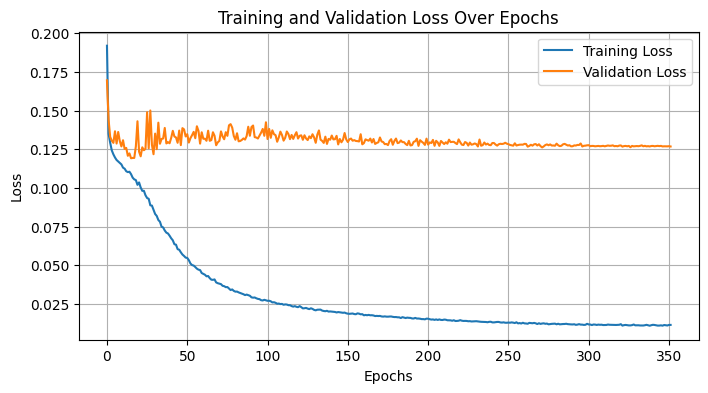

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#### Evaluate the model on validation data

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


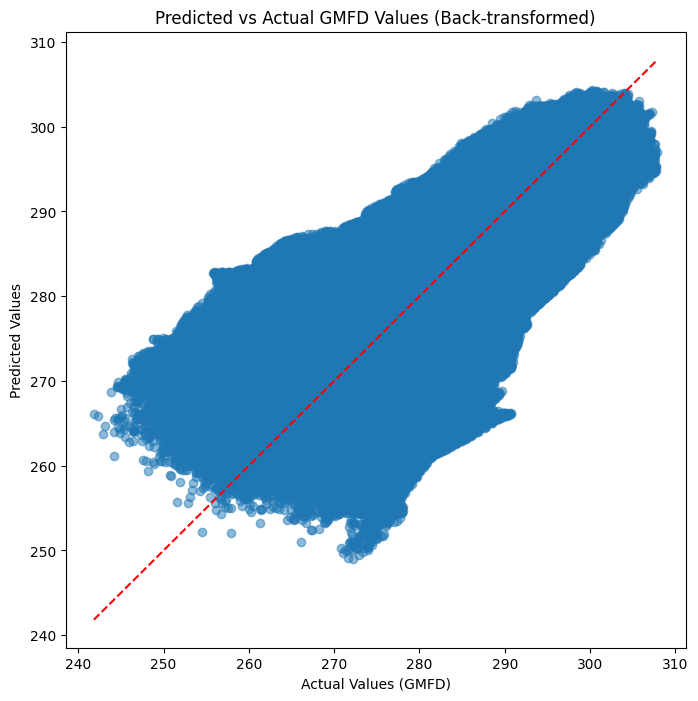

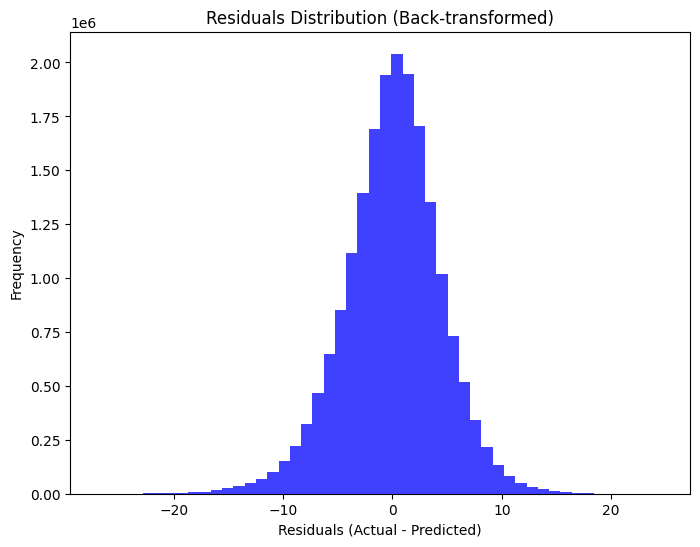

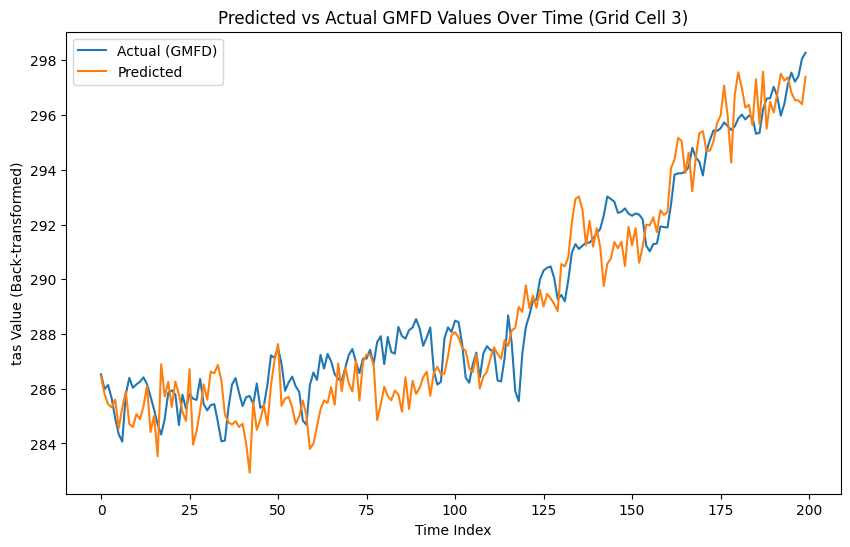

In [8]:
# Back-transform function
def denormalize(data, mean, std):
    return (data * std) + mean

# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values

# Get the mean and std from the training set for denormalization
gmfd_mean = gmfd_data['tas'].mean().values
gmfd_std = gmfd_data['tas'].std().values

# # Evaluate on the denormalized test data
# val_mse, val_mae = model.evaluate(X_test, y_test, verbose=1)
# print(f"Validation MAE: {val_mae}")
# print(f"Validation MSE: {val_mse}")


# Generate predictions on validation data
y_pred = model.predict(X_val)


# Back-transform the predictions for evaluation
y_val_denorm = denormalize(y_val, cmip6_high_res_mean, cmip6_high_res_std)
y_pred_denorm = denormalize(y_pred, cmip6_high_res_mean, cmip6_high_res_std)

# Plot: Predicted vs Actual Values (back-transformed)
plt.figure(figsize=(8, 8))
plt.scatter(y_val_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_val_denorm.min(), y_val_denorm.max()], [y_val_denorm.min(), y_val_denorm.max()], 'r--')  # Line of perfect prediction
plt.show()

# Plot: Residuals (Actual - Predicted) after back-transform
residuals_denorm = y_val_denorm.flatten() - y_pred_denorm.flatten()
plt.figure(figsize=(8, 6))
plt.hist(residuals_denorm, bins=50, alpha=0.75, color='blue')
plt.title('Residuals Distribution (Back-transformed)')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# Plot: Predicted and Actual Values Over Time for a Specific Grid Cell (Back-transformed)
# Select a grid cell (e.g., the first one)
grid_cell_index = 3
plt.figure(figsize=(10, 6))
plt.plot(y_val_denorm[:200, grid_cell_index, 0].flatten(), label='Actual (GMFD)')
plt.plot(y_pred_denorm[:200, grid_cell_index, 0].flatten(), label='Predicted')
plt.xlabel('Time Index')
plt.ylabel('tas Value (Back-transformed)')
plt.title(f'Predicted vs Actual GMFD Values Over Time (Grid Cell {grid_cell_index})')
plt.legend()
plt.show()


#### Train the Best Model on All Data
Train the model on all the data (no splitting)

In [10]:
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)
model = climate_unet(input_shape)
epochs = 1500
# Learning rate schedule with warmup and cosine decay
initial_learning_rate = 1e-3
total_steps = int(np.ceil(len(X_train) / 32)) * epochs

lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps=total_steps//4,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-5
)

# Optimizer configuration
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)

# Initialize the custom loss function
climate_loss = ClimateDownscalingLossJAX()

# Compile model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Simplified callbacks
callbacks = [
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    
    # Learning rate monitoring
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Model checkpointing
    keras.callbacks.ModelCheckpoint(
        'models/unet_best_model.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=1
    ),
    
    # Terminate on NaN
    keras.callbacks.TerminateOnNaN()
]

# Training settings
epochs = 1500
batch_size = 64

# Calculate total batches
total_batches = int(np.ceil(len(X_train) / batch_size) * epochs)

# Initialize history
history = {
    'loss': [],
    'val_loss': [],
    'mean_absolute_error': [],
    'val_mean_absolute_error': [],
    'root_mean_squared_error': [],
    'val_root_mean_squared_error': [],
    'learning_rate': []
}


# Training loop
with tqdm(total=total_batches, desc='Training', unit='batch') as pbar:
    for epoch in range(epochs):
        # Training epoch
        history_epoch = model.fit(
            cmip6_train_reshaped, gmfd_train_reshaped,
            validation_split=0.2,
            epochs=1,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )
        
        # Update history
        for key in history_epoch.history:
            history[key].append(history_epoch.history[key][0])
        
        # Get current learning rate
        current_lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate))
        history['learning_rate'].append(current_lr)

        # Update progress bar
        pbar.set_postfix({
            'epoch': epoch + 1,
            'loss': f"{history['loss'][-1]:.4f}",
            'val_loss': f"{history['val_loss'][-1]:.4f}",
            'mae': f"{history['mean_absolute_error'][-1]:.4f}",
            'lr': f"{current_lr:.2e}"
})
        
        # Update progress
        pbar.update(int(np.ceil(len(X_train) / batch_size)))
        
        # Early stopping check
        if len(history['val_loss']) > 20:
            best_loss = min(history['val_loss'][:-20])
            recent_best = min(history['val_loss'][-20:])
            if recent_best >= best_loss and current_lr <= 1e-5:
                print("\nEarly stopping triggered: No improvement in validation loss")
                break

# Finalize training
print("Training completed.")
model.save('models/unet_CNRM-ESM2-1.keras')  # keras format


Training:   0%|                                                                                     | 0/669000 [00:00<?, ?batch/s]


Epoch 1: val_loss improved from inf to 0.16941, saving model to models/unet_best_model.weights.h5


Training:   0%|        | 446/669000 [01:16<31:56:24,  5.81batch/s, epoch=1, loss=0.1724, val_loss=0.1694, mae=0.4121, lr=1.00e-03]


Epoch 1: val_loss improved from 0.16941 to 0.13818, saving model to models/unet_best_model.weights.h5


Training:   0%|        | 892/669000 [02:04<21:36:06,  8.59batch/s, epoch=2, loss=0.1308, val_loss=0.1382, mae=0.3760, lr=1.00e-03]


Epoch 1: val_loss did not improve from 0.13818


Training:   0%|       | 1338/669000 [02:24<15:09:19, 12.24batch/s, epoch=3, loss=0.1254, val_loss=0.1500, mae=0.3683, lr=1.00e-03]


Epoch 1: val_loss improved from 0.13818 to 0.13695, saving model to models/unet_best_model.weights.h5


Training:   0%|       | 1784/669000 [02:44<12:17:42, 15.07batch/s, epoch=4, loss=0.1222, val_loss=0.1370, mae=0.3651, lr=1.00e-03]


Epoch 1: val_loss did not improve from 0.13695


Training:   0%|       | 2230/669000 [02:46<10:33:33, 17.54batch/s, epoch=5, loss=0.1198, val_loss=0.1518, mae=0.3625, lr=9.99e-04]


Epoch 1: val_loss improved from 0.13695 to 0.13643, saving model to models/unet_best_model.weights.h5


Training:   0%|        | 2676/669000 [03:05<9:38:55, 19.18batch/s, epoch=6, loss=0.1174, val_loss=0.1364, mae=0.3590, lr=9.99e-04]


Epoch 1: val_loss improved from 0.13643 to 0.13032, saving model to models/unet_best_model.weights.h5


Training:   0%|        | 3122/669000 [03:34<9:03:35, 20.42batch/s, epoch=7, loss=0.1161, val_loss=0.1303, mae=0.3572, lr=9.98e-04]


Epoch 1: val_loss did not improve from 0.13032


Training:   1%|        | 3568/669000 [03:54<8:31:32, 21.68batch/s, epoch=8, loss=0.1147, val_loss=0.1317, mae=0.3554, lr=9.98e-04]


Epoch 1: val_loss improved from 0.13032 to 0.12879, saving model to models/unet_best_model.weights.h5


Training:   1%|        | 4014/669000 [04:14<8:18:16, 22.24batch/s, epoch=9, loss=0.1143, val_loss=0.1288, mae=0.3547, lr=9.97e-04]


Epoch 1: val_loss improved from 0.12879 to 0.12590, saving model to models/unet_best_model.weights.h5


Training:   1%|       | 4460/669000 [04:34<8:09:12, 22.64batch/s, epoch=10, loss=0.1127, val_loss=0.1259, mae=0.3523, lr=9.97e-04]


Epoch 1: val_loss did not improve from 0.12590


Training:   1%|       | 4906/669000 [04:54<7:54:06, 23.35batch/s, epoch=11, loss=0.1115, val_loss=0.1322, mae=0.3508, lr=9.96e-04]


Epoch 1: val_loss improved from 0.12590 to 0.12443, saving model to models/unet_best_model.weights.h5


Training:   1%|       | 5352/669000 [04:56<7:52:58, 23.39batch/s, epoch=12, loss=0.1109, val_loss=0.1244, mae=0.3500, lr=9.96e-04]


Epoch 1: val_loss did not improve from 0.12443


Training:   1%|       | 5798/669000 [05:14<7:42:56, 23.88batch/s, epoch=13, loss=0.1090, val_loss=0.1285, mae=0.3469, lr=9.95e-04]


Epoch 1: val_loss did not improve from 0.12443


Training:   1%|       | 6244/669000 [05:44<7:35:54, 24.23batch/s, epoch=14, loss=0.1079, val_loss=0.1288, mae=0.3453, lr=9.94e-04]


Epoch 1: val_loss improved from 0.12443 to 0.12313, saving model to models/unet_best_model.weights.h5


Training:   1%|       | 6690/669000 [06:04<7:39:00, 24.05batch/s, epoch=15, loss=0.1081, val_loss=0.1231, mae=0.3447, lr=9.93e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   1%|       | 7136/669000 [06:24<7:32:37, 24.37batch/s, epoch=16, loss=0.1060, val_loss=0.1325, mae=0.3409, lr=9.92e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   1%|       | 7582/669000 [06:44<7:35:35, 24.20batch/s, epoch=17, loss=0.1056, val_loss=0.1249, mae=0.3411, lr=9.91e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   1%|       | 8028/669000 [06:45<7:32:11, 24.36batch/s, epoch=18, loss=0.1041, val_loss=0.1339, mae=0.3386, lr=9.90e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   1%|       | 8474/669000 [07:14<7:28:49, 24.53batch/s, epoch=19, loss=0.1030, val_loss=0.1281, mae=0.3368, lr=9.89e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   1%|       | 8920/669000 [07:34<7:27:01, 24.61batch/s, epoch=20, loss=0.1013, val_loss=0.1253, mae=0.3341, lr=9.88e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   1%|       | 9366/669000 [07:54<7:25:34, 24.67batch/s, epoch=21, loss=0.0998, val_loss=0.1316, mae=0.3318, lr=9.86e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   1%|       | 9812/669000 [08:14<7:23:10, 24.79batch/s, epoch=22, loss=0.0981, val_loss=0.1291, mae=0.3283, lr=9.85e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|      | 10258/669000 [08:15<7:21:30, 24.87batch/s, epoch=23, loss=0.0962, val_loss=0.1287, mae=0.3247, lr=9.84e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|      | 10704/669000 [08:44<7:19:49, 24.95batch/s, epoch=24, loss=0.0949, val_loss=0.1387, mae=0.3225, lr=9.82e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|      | 11150/669000 [09:04<7:18:40, 24.99batch/s, epoch=25, loss=0.0932, val_loss=0.1371, mae=0.3195, lr=9.81e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|      | 11596/669000 [09:24<7:17:33, 25.04batch/s, epoch=26, loss=0.0908, val_loss=0.1301, mae=0.3152, lr=9.79e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|      | 12042/669000 [09:26<7:16:33, 25.08batch/s, epoch=27, loss=0.0894, val_loss=0.1350, mae=0.3125, lr=9.77e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|      | 12488/669000 [09:54<7:16:01, 25.09batch/s, epoch=28, loss=0.0878, val_loss=0.1370, mae=0.3103, lr=9.76e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|      | 12934/669000 [10:14<7:15:13, 25.12batch/s, epoch=29, loss=0.0849, val_loss=0.1294, mae=0.3046, lr=9.74e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|      | 13380/669000 [10:34<7:14:44, 25.13batch/s, epoch=30, loss=0.0832, val_loss=0.1296, mae=0.3013, lr=9.72e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|      | 13826/669000 [10:54<7:14:16, 25.14batch/s, epoch=31, loss=0.0822, val_loss=0.1334, mae=0.2989, lr=9.70e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|▏     | 14272/669000 [10:55<7:15:49, 25.04batch/s, epoch=32, loss=0.0801, val_loss=0.1428, mae=0.2947, lr=9.68e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|▏     | 14718/669000 [11:24<7:16:37, 24.97batch/s, epoch=33, loss=0.0789, val_loss=0.1299, mae=0.2928, lr=9.66e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|▏     | 15164/669000 [11:44<7:15:35, 25.02batch/s, epoch=34, loss=0.0761, val_loss=0.1359, mae=0.2872, lr=9.64e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|▏     | 15610/669000 [12:04<7:15:00, 25.03batch/s, epoch=35, loss=0.0753, val_loss=0.1369, mae=0.2851, lr=9.62e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|▏     | 16056/669000 [12:06<7:15:10, 25.01batch/s, epoch=36, loss=0.0735, val_loss=0.1339, mae=0.2817, lr=9.60e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   2%|▏     | 16502/669000 [12:34<7:14:20, 25.04batch/s, epoch=37, loss=0.0707, val_loss=0.1315, mae=0.2759, lr=9.58e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 16948/669000 [12:54<7:13:45, 25.05batch/s, epoch=38, loss=0.0704, val_loss=0.1393, mae=0.2748, lr=9.56e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 17394/669000 [13:14<7:12:45, 25.09batch/s, epoch=39, loss=0.0688, val_loss=0.1372, mae=0.2714, lr=9.53e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 17840/669000 [13:34<7:11:53, 25.13batch/s, epoch=40, loss=0.0670, val_loss=0.1358, mae=0.2672, lr=9.51e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 18286/669000 [13:35<7:11:25, 25.14batch/s, epoch=41, loss=0.0657, val_loss=0.1336, mae=0.2642, lr=9.49e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 18732/669000 [14:04<7:10:39, 25.17batch/s, epoch=42, loss=0.0643, val_loss=0.1366, mae=0.2606, lr=9.46e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 19178/669000 [14:24<7:10:00, 25.19batch/s, epoch=43, loss=0.0634, val_loss=0.1398, mae=0.2589, lr=9.44e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 19624/669000 [14:44<7:09:35, 25.19batch/s, epoch=44, loss=0.0614, val_loss=0.1362, mae=0.2541, lr=9.41e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 20070/669000 [14:45<7:09:30, 25.18batch/s, epoch=45, loss=0.0607, val_loss=0.1412, mae=0.2522, lr=9.38e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 20516/669000 [15:14<7:08:47, 25.21batch/s, epoch=46, loss=0.0587, val_loss=0.1422, mae=0.2474, lr=9.36e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 20962/669000 [15:34<7:08:19, 25.22batch/s, epoch=47, loss=0.0588, val_loss=0.1372, mae=0.2474, lr=9.33e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 21408/669000 [15:54<7:07:57, 25.22batch/s, epoch=48, loss=0.0569, val_loss=0.1373, mae=0.2422, lr=9.30e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 21854/669000 [15:56<7:07:48, 25.21batch/s, epoch=49, loss=0.0558, val_loss=0.1372, mae=0.2396, lr=9.27e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 22300/669000 [16:24<7:07:19, 25.22batch/s, epoch=50, loss=0.0546, val_loss=0.1433, mae=0.2365, lr=9.24e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 22746/669000 [16:44<7:07:19, 25.21batch/s, epoch=51, loss=0.0532, val_loss=0.1382, mae=0.2328, lr=9.21e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   3%|▏     | 23192/669000 [17:04<7:06:55, 25.21batch/s, epoch=52, loss=0.0523, val_loss=0.1400, mae=0.2303, lr=9.18e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 23638/669000 [17:07<7:06:48, 25.20batch/s, epoch=53, loss=0.0512, val_loss=0.1371, mae=0.2269, lr=9.15e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 24084/669000 [17:25<7:06:45, 25.19batch/s, epoch=54, loss=0.0501, val_loss=0.1488, mae=0.2243, lr=9.12e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 24530/669000 [17:54<7:06:13, 25.20batch/s, epoch=55, loss=0.0493, val_loss=0.1394, mae=0.2213, lr=9.09e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 24976/669000 [18:14<7:05:37, 25.22batch/s, epoch=56, loss=0.0475, val_loss=0.1419, mae=0.2171, lr=9.06e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 25422/669000 [18:34<7:06:34, 25.14batch/s, epoch=57, loss=0.0468, val_loss=0.1453, mae=0.2144, lr=9.02e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 25868/669000 [18:36<7:06:47, 25.12batch/s, epoch=58, loss=0.0465, val_loss=0.1469, mae=0.2137, lr=8.99e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 26314/669000 [19:04<7:06:22, 25.12batch/s, epoch=59, loss=0.0453, val_loss=0.1438, mae=0.2102, lr=8.96e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 26760/669000 [19:24<7:06:11, 25.11batch/s, epoch=60, loss=0.0447, val_loss=0.1402, mae=0.2086, lr=8.92e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 27206/669000 [19:44<7:05:41, 25.13batch/s, epoch=61, loss=0.0440, val_loss=0.1374, mae=0.2065, lr=8.89e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▏     | 27652/669000 [19:46<7:04:56, 25.15batch/s, epoch=62, loss=0.0432, val_loss=0.1406, mae=0.2039, lr=8.85e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▎     | 28098/669000 [20:14<7:04:48, 25.14batch/s, epoch=63, loss=0.0419, val_loss=0.1445, mae=0.1999, lr=8.81e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▎     | 28544/669000 [20:34<7:04:48, 25.13batch/s, epoch=64, loss=0.0415, val_loss=0.1391, mae=0.1984, lr=8.78e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▎     | 28990/669000 [20:54<7:04:09, 25.15batch/s, epoch=65, loss=0.0408, val_loss=0.1413, mae=0.1964, lr=8.74e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▎     | 29436/669000 [21:14<7:04:00, 25.14batch/s, epoch=66, loss=0.0400, val_loss=0.1451, mae=0.1937, lr=8.70e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   4%|▎     | 29882/669000 [21:15<7:03:38, 25.14batch/s, epoch=67, loss=0.0397, val_loss=0.1397, mae=0.1935, lr=8.67e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 30328/669000 [21:44<7:02:58, 25.17batch/s, epoch=68, loss=0.0386, val_loss=0.1385, mae=0.1893, lr=8.63e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 30774/669000 [22:04<7:02:37, 25.17batch/s, epoch=69, loss=0.0383, val_loss=0.1391, mae=0.1885, lr=8.59e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 31220/669000 [22:24<7:02:04, 25.18batch/s, epoch=70, loss=0.0376, val_loss=0.1373, mae=0.1861, lr=8.55e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 31666/669000 [22:26<7:02:03, 25.17batch/s, epoch=71, loss=0.0367, val_loss=0.1416, mae=0.1827, lr=8.51e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 32112/669000 [22:54<7:01:48, 25.17batch/s, epoch=72, loss=0.0364, val_loss=0.1402, mae=0.1822, lr=8.47e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 32558/669000 [23:14<7:02:06, 25.13batch/s, epoch=73, loss=0.0368, val_loss=0.1401, mae=0.1837, lr=8.43e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 33004/669000 [23:34<7:02:01, 25.12batch/s, epoch=74, loss=0.0353, val_loss=0.1471, mae=0.1782, lr=8.39e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 33450/669000 [23:54<7:01:23, 25.14batch/s, epoch=75, loss=0.0351, val_loss=0.1384, mae=0.1780, lr=8.35e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 33896/669000 [23:55<7:01:21, 25.12batch/s, epoch=76, loss=0.0341, val_loss=0.1423, mae=0.1746, lr=8.31e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 34342/669000 [24:24<7:00:55, 25.13batch/s, epoch=77, loss=0.0338, val_loss=0.1452, mae=0.1735, lr=8.27e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 34788/669000 [24:44<7:00:18, 25.15batch/s, epoch=78, loss=0.0338, val_loss=0.1400, mae=0.1729, lr=8.22e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 35234/669000 [25:04<6:59:55, 25.15batch/s, epoch=79, loss=0.0326, val_loss=0.1404, mae=0.1692, lr=8.18e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 35680/669000 [25:06<6:59:52, 25.14batch/s, epoch=80, loss=0.0325, val_loss=0.1429, mae=0.1692, lr=8.14e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 36126/669000 [25:34<6:59:21, 25.15batch/s, epoch=81, loss=0.0320, val_loss=0.1411, mae=0.1669, lr=8.09e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   5%|▎     | 36572/669000 [25:54<6:59:16, 25.14batch/s, epoch=82, loss=0.0318, val_loss=0.1460, mae=0.1669, lr=8.05e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 37018/669000 [26:14<6:58:55, 25.14batch/s, epoch=83, loss=0.0314, val_loss=0.1417, mae=0.1652, lr=8.00e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 37464/669000 [26:17<6:58:43, 25.14batch/s, epoch=84, loss=0.0307, val_loss=0.1426, mae=0.1620, lr=7.96e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 37910/669000 [26:35<6:58:45, 25.12batch/s, epoch=85, loss=0.0306, val_loss=0.1419, mae=0.1622, lr=7.91e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 38356/669000 [27:04<6:58:24, 25.12batch/s, epoch=86, loss=0.0304, val_loss=0.1433, mae=0.1610, lr=7.87e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 38802/669000 [27:24<6:57:47, 25.14batch/s, epoch=87, loss=0.0299, val_loss=0.1402, mae=0.1599, lr=7.82e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 39248/669000 [27:44<6:57:07, 25.16batch/s, epoch=88, loss=0.0298, val_loss=0.1412, mae=0.1593, lr=7.78e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 39694/669000 [27:45<6:56:55, 25.16batch/s, epoch=89, loss=0.0294, val_loss=0.1447, mae=0.1580, lr=7.73e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 40140/669000 [28:14<6:56:40, 25.15batch/s, epoch=90, loss=0.0285, val_loss=0.1390, mae=0.1546, lr=7.68e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 40586/669000 [28:34<6:56:09, 25.17batch/s, epoch=91, loss=0.0288, val_loss=0.1427, mae=0.1559, lr=7.64e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 41032/669000 [28:54<6:55:38, 25.18batch/s, epoch=92, loss=0.0282, val_loss=0.1408, mae=0.1539, lr=7.59e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▎     | 41478/669000 [28:56<6:55:05, 25.20batch/s, epoch=93, loss=0.0281, val_loss=0.1400, mae=0.1533, lr=7.54e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▍     | 41924/669000 [29:24<6:54:47, 25.20batch/s, epoch=94, loss=0.0277, val_loss=0.1421, mae=0.1519, lr=7.49e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▍     | 42370/669000 [29:44<6:55:06, 25.16batch/s, epoch=95, loss=0.0271, val_loss=0.1411, mae=0.1493, lr=7.44e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▍     | 42816/669000 [30:04<6:54:30, 25.18batch/s, epoch=96, loss=0.0269, val_loss=0.1383, mae=0.1483, lr=7.40e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   6%|▍     | 43262/669000 [30:24<6:54:18, 25.17batch/s, epoch=97, loss=0.0267, val_loss=0.1424, mae=0.1476, lr=7.35e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▍     | 43708/669000 [30:25<6:54:06, 25.17batch/s, epoch=98, loss=0.0266, val_loss=0.1435, mae=0.1473, lr=7.30e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▍     | 44154/669000 [30:54<6:53:57, 25.16batch/s, epoch=99, loss=0.0261, val_loss=0.1395, mae=0.1450, lr=7.25e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 44600/669000 [31:14<6:53:36, 25.16batch/s, epoch=100, loss=0.0257, val_loss=0.1379, mae=0.1435, lr=7.20e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 45046/669000 [31:34<6:53:07, 25.17batch/s, epoch=101, loss=0.0259, val_loss=0.1419, mae=0.1446, lr=7.15e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 45492/669000 [31:36<6:52:42, 25.18batch/s, epoch=102, loss=0.0256, val_loss=0.1414, mae=0.1435, lr=7.10e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 45938/669000 [32:04<6:52:31, 25.17batch/s, epoch=103, loss=0.0252, val_loss=0.1384, mae=0.1417, lr=7.05e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 46384/669000 [32:24<6:52:19, 25.17batch/s, epoch=104, loss=0.0253, val_loss=0.1392, mae=0.1425, lr=6.99e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 46830/669000 [32:44<6:51:52, 25.18batch/s, epoch=105, loss=0.0248, val_loss=0.1428, mae=0.1405, lr=6.94e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 47276/669000 [32:47<6:51:36, 25.17batch/s, epoch=106, loss=0.0246, val_loss=0.1406, mae=0.1389, lr=6.89e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 47722/669000 [33:14<6:51:32, 25.16batch/s, epoch=107, loss=0.0245, val_loss=0.1414, mae=0.1389, lr=6.84e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 48168/669000 [33:34<6:50:56, 25.18batch/s, epoch=108, loss=0.0244, val_loss=0.1377, mae=0.1389, lr=6.79e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 48614/669000 [33:54<6:50:45, 25.17batch/s, epoch=109, loss=0.0241, val_loss=0.1440, mae=0.1375, lr=6.74e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 49060/669000 [34:14<6:50:28, 25.17batch/s, epoch=110, loss=0.0242, val_loss=0.1421, mae=0.1383, lr=6.68e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 49506/669000 [34:15<6:49:58, 25.18batch/s, epoch=111, loss=0.0237, val_loss=0.1459, mae=0.1361, lr=6.63e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   7%|▎    | 49952/669000 [34:44<6:49:36, 25.19batch/s, epoch=112, loss=0.0235, val_loss=0.1396, mae=0.1350, lr=6.58e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 50398/669000 [35:04<6:49:32, 25.17batch/s, epoch=113, loss=0.0235, val_loss=0.1389, mae=0.1350, lr=6.53e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 50844/669000 [35:24<6:50:34, 25.09batch/s, epoch=114, loss=0.0229, val_loss=0.1406, mae=0.1325, lr=6.47e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 51290/669000 [35:26<6:50:37, 25.07batch/s, epoch=115, loss=0.0230, val_loss=0.1411, mae=0.1332, lr=6.42e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 51736/669000 [35:54<6:50:11, 25.08batch/s, epoch=116, loss=0.0224, val_loss=0.1404, mae=0.1301, lr=6.37e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 52182/669000 [36:14<6:49:52, 25.08batch/s, epoch=117, loss=0.0225, val_loss=0.1442, mae=0.1310, lr=6.31e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 52628/669000 [36:34<6:49:23, 25.09batch/s, epoch=118, loss=0.0221, val_loss=0.1413, mae=0.1290, lr=6.26e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 53074/669000 [36:54<6:49:28, 25.07batch/s, epoch=119, loss=0.0221, val_loss=0.1426, mae=0.1298, lr=6.20e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 53520/669000 [36:55<6:49:14, 25.07batch/s, epoch=120, loss=0.0220, val_loss=0.1388, mae=0.1287, lr=6.15e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 53966/669000 [37:24<6:48:45, 25.08batch/s, epoch=121, loss=0.0218, val_loss=0.1410, mae=0.1275, lr=6.09e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 54412/669000 [37:44<6:47:50, 25.12batch/s, epoch=122, loss=0.0217, val_loss=0.1393, mae=0.1278, lr=6.04e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 54858/669000 [38:04<6:47:25, 25.12batch/s, epoch=123, loss=0.0217, val_loss=0.1402, mae=0.1263, lr=5.99e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 55304/669000 [38:06<6:47:02, 25.13batch/s, epoch=124, loss=0.0213, val_loss=0.1406, mae=0.1257, lr=5.93e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 55750/669000 [38:34<6:47:18, 25.09batch/s, epoch=125, loss=0.0212, val_loss=0.1410, mae=0.1253, lr=5.88e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 56196/669000 [38:54<6:46:29, 25.13batch/s, epoch=126, loss=0.0212, val_loss=0.1399, mae=0.1254, lr=5.82e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   8%|▍    | 56642/669000 [39:14<6:45:56, 25.14batch/s, epoch=127, loss=0.0212, val_loss=0.1412, mae=0.1259, lr=5.77e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 57088/669000 [39:34<6:45:38, 25.14batch/s, epoch=128, loss=0.0211, val_loss=0.1408, mae=0.1253, lr=5.71e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 57534/669000 [39:35<6:45:12, 25.15batch/s, epoch=129, loss=0.0209, val_loss=0.1391, mae=0.1242, lr=5.66e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 57980/669000 [40:04<6:44:58, 25.15batch/s, epoch=130, loss=0.0207, val_loss=0.1390, mae=0.1236, lr=5.60e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 58426/669000 [40:24<6:44:28, 25.16batch/s, epoch=131, loss=0.0206, val_loss=0.1405, mae=0.1238, lr=5.54e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 58872/669000 [40:44<6:44:06, 25.16batch/s, epoch=132, loss=0.0204, val_loss=0.1394, mae=0.1220, lr=5.49e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 59318/669000 [40:46<6:43:58, 25.15batch/s, epoch=133, loss=0.0200, val_loss=0.1376, mae=0.1200, lr=5.43e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 59764/669000 [41:14<6:43:55, 25.14batch/s, epoch=134, loss=0.0202, val_loss=0.1389, mae=0.1218, lr=5.38e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 60210/669000 [41:34<6:43:28, 25.15batch/s, epoch=135, loss=0.0201, val_loss=0.1383, mae=0.1210, lr=5.32e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 60656/669000 [41:54<6:43:08, 25.15batch/s, epoch=136, loss=0.0198, val_loss=0.1395, mae=0.1190, lr=5.27e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 61102/669000 [41:57<6:43:01, 25.14batch/s, epoch=137, loss=0.0199, val_loss=0.1378, mae=0.1206, lr=5.21e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 61548/669000 [42:15<6:43:04, 25.12batch/s, epoch=138, loss=0.0197, val_loss=0.1373, mae=0.1198, lr=5.16e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 61994/669000 [42:44<6:42:33, 25.13batch/s, epoch=139, loss=0.0195, val_loss=0.1383, mae=0.1181, lr=5.10e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 62440/669000 [43:04<6:42:39, 25.11batch/s, epoch=140, loss=0.0194, val_loss=0.1392, mae=0.1176, lr=5.04e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 62886/669000 [43:24<6:42:01, 25.13batch/s, epoch=141, loss=0.0193, val_loss=0.1407, mae=0.1173, lr=4.99e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:   9%|▍    | 63332/669000 [43:26<6:41:26, 25.15batch/s, epoch=142, loss=0.0192, val_loss=0.1382, mae=0.1170, lr=4.93e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▍    | 63778/669000 [43:54<6:41:18, 25.14batch/s, epoch=143, loss=0.0190, val_loss=0.1383, mae=0.1167, lr=4.88e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▍    | 64224/669000 [44:14<6:40:44, 25.15batch/s, epoch=144, loss=0.0187, val_loss=0.1415, mae=0.1145, lr=4.82e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▍    | 64670/669000 [44:34<6:40:13, 25.17batch/s, epoch=145, loss=0.0186, val_loss=0.1415, mae=0.1140, lr=4.76e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▍    | 65116/669000 [44:37<6:40:36, 25.12batch/s, epoch=146, loss=0.0188, val_loss=0.1389, mae=0.1149, lr=4.71e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▍    | 65562/669000 [45:04<6:39:59, 25.14batch/s, epoch=147, loss=0.0187, val_loss=0.1400, mae=0.1149, lr=4.65e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▍    | 66008/669000 [45:24<6:40:13, 25.11batch/s, epoch=148, loss=0.0184, val_loss=0.1360, mae=0.1130, lr=4.60e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▍    | 66454/669000 [45:44<6:39:40, 25.13batch/s, epoch=149, loss=0.0183, val_loss=0.1386, mae=0.1130, lr=4.54e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▌    | 66900/669000 [46:04<6:39:12, 25.14batch/s, epoch=150, loss=0.0184, val_loss=0.1395, mae=0.1133, lr=4.49e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▌    | 67346/669000 [46:05<6:38:31, 25.16batch/s, epoch=151, loss=0.0184, val_loss=0.1402, mae=0.1139, lr=4.43e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▌    | 67792/669000 [46:35<6:38:06, 25.17batch/s, epoch=152, loss=0.0182, val_loss=0.1381, mae=0.1129, lr=4.38e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▌    | 68238/669000 [46:55<6:37:52, 25.17batch/s, epoch=153, loss=0.0184, val_loss=0.1400, mae=0.1138, lr=4.32e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▌    | 68684/669000 [47:15<6:37:24, 25.18batch/s, epoch=154, loss=0.0181, val_loss=0.1372, mae=0.1122, lr=4.27e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▌    | 69130/669000 [47:16<6:37:00, 25.18batch/s, epoch=155, loss=0.0179, val_loss=0.1375, mae=0.1111, lr=4.21e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▌    | 69576/669000 [47:45<6:36:41, 25.18batch/s, epoch=156, loss=0.0179, val_loss=0.1390, mae=0.1113, lr=4.16e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  10%|▌    | 70022/669000 [48:05<6:36:34, 25.17batch/s, epoch=157, loss=0.0177, val_loss=0.1373, mae=0.1102, lr=4.10e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 70468/669000 [48:25<6:36:02, 25.19batch/s, epoch=158, loss=0.0180, val_loss=0.1388, mae=0.1120, lr=4.05e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 70914/669000 [48:27<6:35:42, 25.19batch/s, epoch=159, loss=0.0176, val_loss=0.1359, mae=0.1095, lr=3.99e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 71360/669000 [48:55<6:35:21, 25.19batch/s, epoch=160, loss=0.0176, val_loss=0.1377, mae=0.1097, lr=3.94e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 71806/669000 [49:15<6:34:54, 25.20batch/s, epoch=161, loss=0.0176, val_loss=0.1370, mae=0.1101, lr=3.88e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 72252/669000 [49:35<6:34:41, 25.20batch/s, epoch=162, loss=0.0172, val_loss=0.1364, mae=0.1074, lr=3.83e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 72698/669000 [49:55<6:34:24, 25.20batch/s, epoch=163, loss=0.0171, val_loss=0.1373, mae=0.1071, lr=3.77e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 73144/669000 [49:55<6:33:53, 25.21batch/s, epoch=164, loss=0.0168, val_loss=0.1373, mae=0.1053, lr=3.72e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 73590/669000 [50:25<6:33:51, 25.20batch/s, epoch=165, loss=0.0173, val_loss=0.1378, mae=0.1090, lr=3.67e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 74036/669000 [50:45<6:33:49, 25.18batch/s, epoch=166, loss=0.0172, val_loss=0.1380, mae=0.1083, lr=3.61e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 74482/669000 [51:05<6:33:47, 25.16batch/s, epoch=167, loss=0.0170, val_loss=0.1386, mae=0.1064, lr=3.56e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 74928/669000 [51:06<6:33:17, 25.18batch/s, epoch=168, loss=0.0171, val_loss=0.1374, mae=0.1077, lr=3.50e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 75374/669000 [51:35<6:33:08, 25.17batch/s, epoch=169, loss=0.0170, val_loss=0.1389, mae=0.1067, lr=3.45e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 75820/669000 [51:55<6:32:55, 25.16batch/s, epoch=170, loss=0.0171, val_loss=0.1379, mae=0.1079, lr=3.40e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 76266/669000 [52:15<6:32:47, 25.15batch/s, epoch=171, loss=0.0168, val_loss=0.1379, mae=0.1055, lr=3.35e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  11%|▌    | 76712/669000 [52:35<6:32:50, 25.13batch/s, epoch=172, loss=0.0168, val_loss=0.1374, mae=0.1059, lr=3.29e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 77158/669000 [52:35<6:32:52, 25.11batch/s, epoch=173, loss=0.0171, val_loss=0.1370, mae=0.1084, lr=3.24e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 77604/669000 [53:05<6:32:27, 25.12batch/s, epoch=174, loss=0.0171, val_loss=0.1374, mae=0.1090, lr=3.19e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 78050/669000 [53:25<6:31:45, 25.14batch/s, epoch=175, loss=0.0166, val_loss=0.1387, mae=0.1045, lr=3.14e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 78496/669000 [53:45<6:31:37, 25.13batch/s, epoch=176, loss=0.0169, val_loss=0.1375, mae=0.1062, lr=3.09e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 78942/669000 [53:46<6:31:04, 25.15batch/s, epoch=177, loss=0.0168, val_loss=0.1374, mae=0.1069, lr=3.03e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 79388/669000 [54:15<6:30:40, 25.15batch/s, epoch=178, loss=0.0166, val_loss=0.1351, mae=0.1050, lr=2.98e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 79834/669000 [54:35<6:30:24, 25.15batch/s, epoch=179, loss=0.0168, val_loss=0.1374, mae=0.1060, lr=2.93e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 80280/669000 [54:55<6:30:10, 25.15batch/s, epoch=180, loss=0.0170, val_loss=0.1380, mae=0.1080, lr=2.88e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 80726/669000 [54:57<6:29:47, 25.15batch/s, epoch=181, loss=0.0165, val_loss=0.1386, mae=0.1046, lr=2.83e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 81172/669000 [55:15<6:30:52, 25.06batch/s, epoch=182, loss=0.0163, val_loss=0.1369, mae=0.1029, lr=2.78e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 81618/669000 [55:45<6:30:35, 25.06batch/s, epoch=183, loss=0.0165, val_loss=0.1377, mae=0.1049, lr=2.73e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 82064/669000 [56:05<6:30:13, 25.07batch/s, epoch=184, loss=0.0163, val_loss=0.1377, mae=0.1036, lr=2.68e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 82510/669000 [56:25<6:29:39, 25.09batch/s, epoch=185, loss=0.0161, val_loss=0.1382, mae=0.1019, lr=2.63e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 82956/669000 [56:26<6:29:38, 25.07batch/s, epoch=186, loss=0.0161, val_loss=0.1360, mae=0.1022, lr=2.58e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  12%|▌    | 83402/669000 [56:55<6:28:51, 25.10batch/s, epoch=187, loss=0.0161, val_loss=0.1380, mae=0.1029, lr=2.53e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 83848/669000 [57:15<6:28:32, 25.10batch/s, epoch=188, loss=0.0159, val_loss=0.1369, mae=0.1013, lr=2.49e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 84294/669000 [57:35<6:28:03, 25.11batch/s, epoch=189, loss=0.0158, val_loss=0.1356, mae=0.1002, lr=2.44e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 84740/669000 [57:37<6:27:40, 25.12batch/s, epoch=190, loss=0.0159, val_loss=0.1371, mae=0.1012, lr=2.39e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 85186/669000 [57:55<6:27:10, 25.13batch/s, epoch=191, loss=0.0158, val_loss=0.1373, mae=0.1011, lr=2.34e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 85632/669000 [58:25<6:27:02, 25.12batch/s, epoch=192, loss=0.0157, val_loss=0.1367, mae=0.1007, lr=2.30e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 86078/669000 [58:45<6:26:25, 25.14batch/s, epoch=193, loss=0.0159, val_loss=0.1376, mae=0.1016, lr=2.25e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 86524/669000 [59:05<6:25:46, 25.16batch/s, epoch=194, loss=0.0159, val_loss=0.1370, mae=0.1021, lr=2.20e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 86970/669000 [59:05<6:25:25, 25.17batch/s, epoch=195, loss=0.0157, val_loss=0.1359, mae=0.1009, lr=2.16e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 87416/669000 [59:35<6:25:24, 25.15batch/s, epoch=196, loss=0.0157, val_loss=0.1372, mae=0.1013, lr=2.11e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▋    | 87862/669000 [59:55<6:24:54, 25.16batch/s, epoch=197, loss=0.0158, val_loss=0.1351, mae=0.1017, lr=2.07e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▍  | 88308/669000 [1:00:15<6:24:35, 25.16batch/s, epoch=198, loss=0.0157, val_loss=0.1363, mae=0.1011, lr=2.02e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▍  | 88754/669000 [1:00:16<6:24:12, 25.17batch/s, epoch=199, loss=0.0154, val_loss=0.1371, mae=0.0994, lr=1.98e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▍  | 89200/669000 [1:00:45<6:23:53, 25.17batch/s, epoch=200, loss=0.0156, val_loss=0.1370, mae=0.1012, lr=1.93e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▍  | 89646/669000 [1:01:05<6:23:42, 25.16batch/s, epoch=201, loss=0.0154, val_loss=0.1369, mae=0.0993, lr=1.89e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  13%|▍  | 90092/669000 [1:01:25<6:23:04, 25.19batch/s, epoch=202, loss=0.0154, val_loss=0.1375, mae=0.1000, lr=1.84e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 90538/669000 [1:01:27<6:22:37, 25.20batch/s, epoch=203, loss=0.0151, val_loss=0.1365, mae=0.0974, lr=1.80e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 90984/669000 [1:01:45<6:22:11, 25.21batch/s, epoch=204, loss=0.0151, val_loss=0.1367, mae=0.0978, lr=1.76e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 91430/669000 [1:02:15<6:21:58, 25.20batch/s, epoch=205, loss=0.0151, val_loss=0.1366, mae=0.0974, lr=1.72e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 91876/669000 [1:02:35<6:21:56, 25.18batch/s, epoch=206, loss=0.0150, val_loss=0.1377, mae=0.0972, lr=1.67e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 92322/669000 [1:02:55<6:21:29, 25.19batch/s, epoch=207, loss=0.0151, val_loss=0.1369, mae=0.0976, lr=1.63e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 92768/669000 [1:02:56<6:21:05, 25.20batch/s, epoch=208, loss=0.0149, val_loss=0.1361, mae=0.0965, lr=1.59e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 93214/669000 [1:03:25<6:21:42, 25.14batch/s, epoch=209, loss=0.0151, val_loss=0.1364, mae=0.0982, lr=1.55e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 93660/669000 [1:03:45<6:21:58, 25.10batch/s, epoch=210, loss=0.0150, val_loss=0.1367, mae=0.0978, lr=1.51e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 94106/669000 [1:04:05<6:21:35, 25.11batch/s, epoch=211, loss=0.0149, val_loss=0.1373, mae=0.0964, lr=1.47e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 94552/669000 [1:04:07<6:21:12, 25.11batch/s, epoch=212, loss=0.0147, val_loss=0.1363, mae=0.0960, lr=1.43e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 94998/669000 [1:04:35<6:20:31, 25.14batch/s, epoch=213, loss=0.0150, val_loss=0.1364, mae=0.0977, lr=1.39e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 95444/669000 [1:04:55<6:20:04, 25.15batch/s, epoch=214, loss=0.0148, val_loss=0.1373, mae=0.0964, lr=1.35e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 95890/669000 [1:05:15<6:19:47, 25.15batch/s, epoch=215, loss=0.0148, val_loss=0.1361, mae=0.0965, lr=1.32e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 96336/669000 [1:05:35<6:19:11, 25.17batch/s, epoch=216, loss=0.0150, val_loss=0.1356, mae=0.0984, lr=1.28e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  14%|▍  | 96782/669000 [1:05:35<6:19:06, 25.16batch/s, epoch=217, loss=0.0147, val_loss=0.1358, mae=0.0958, lr=1.24e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▍  | 97228/669000 [1:06:05<6:18:48, 25.16batch/s, epoch=218, loss=0.0147, val_loss=0.1365, mae=0.0962, lr=1.21e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▍  | 97674/669000 [1:06:25<6:18:32, 25.15batch/s, epoch=219, loss=0.0146, val_loss=0.1365, mae=0.0952, lr=1.17e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▍  | 98120/669000 [1:06:45<6:18:01, 25.17batch/s, epoch=220, loss=0.0149, val_loss=0.1367, mae=0.0979, lr=1.13e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▍  | 98566/669000 [1:06:46<6:17:38, 25.18batch/s, epoch=221, loss=0.0147, val_loss=0.1357, mae=0.0962, lr=1.10e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▍  | 99012/669000 [1:07:15<6:17:34, 25.16batch/s, epoch=222, loss=0.0146, val_loss=0.1359, mae=0.0953, lr=1.06e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▍  | 99458/669000 [1:07:35<6:17:32, 25.14batch/s, epoch=223, loss=0.0144, val_loss=0.1359, mae=0.0946, lr=1.03e-04]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▍  | 99904/669000 [1:07:55<6:17:03, 25.16batch/s, epoch=224, loss=0.0145, val_loss=0.1359, mae=0.0950, lr=9.96e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▎ | 100350/669000 [1:07:57<6:16:42, 25.16batch/s, epoch=225, loss=0.0147, val_loss=0.1372, mae=0.0970, lr=9.63e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▎ | 100796/669000 [1:08:15<6:16:51, 25.13batch/s, epoch=226, loss=0.0146, val_loss=0.1362, mae=0.0962, lr=9.31e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▎ | 101242/669000 [1:08:45<6:16:17, 25.15batch/s, epoch=227, loss=0.0145, val_loss=0.1361, mae=0.0960, lr=8.98e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▎ | 101688/669000 [1:09:05<6:16:39, 25.10batch/s, epoch=228, loss=0.0144, val_loss=0.1364, mae=0.0941, lr=8.67e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▎ | 102134/669000 [1:09:25<6:15:58, 25.13batch/s, epoch=229, loss=0.0143, val_loss=0.1365, mae=0.0942, lr=8.36e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▎ | 102580/669000 [1:09:26<6:15:25, 25.15batch/s, epoch=230, loss=0.0142, val_loss=0.1364, mae=0.0936, lr=8.05e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▎ | 103026/669000 [1:09:55<6:14:57, 25.16batch/s, epoch=231, loss=0.0144, val_loss=0.1373, mae=0.0952, lr=7.75e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  15%|▎ | 103472/669000 [1:10:15<6:14:51, 25.14batch/s, epoch=232, loss=0.0144, val_loss=0.1381, mae=0.0957, lr=7.45e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 103918/669000 [1:10:35<6:14:20, 25.16batch/s, epoch=233, loss=0.0141, val_loss=0.1363, mae=0.0929, lr=7.16e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 104364/669000 [1:10:37<6:14:08, 25.15batch/s, epoch=234, loss=0.0142, val_loss=0.1361, mae=0.0938, lr=6.88e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 104810/669000 [1:11:05<6:13:56, 25.15batch/s, epoch=235, loss=0.0143, val_loss=0.1368, mae=0.0941, lr=6.60e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 105256/669000 [1:11:25<6:13:51, 25.13batch/s, epoch=236, loss=0.0140, val_loss=0.1365, mae=0.0916, lr=6.32e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 105702/669000 [1:11:45<6:13:37, 25.13batch/s, epoch=237, loss=0.0142, val_loss=0.1363, mae=0.0931, lr=6.06e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 106148/669000 [1:12:05<6:13:16, 25.13batch/s, epoch=238, loss=0.0140, val_loss=0.1358, mae=0.0926, lr=5.79e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 106594/669000 [1:12:06<6:13:00, 25.13batch/s, epoch=239, loss=0.0141, val_loss=0.1361, mae=0.0933, lr=5.53e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 107040/669000 [1:12:35<6:12:42, 25.13batch/s, epoch=240, loss=0.0143, val_loss=0.1359, mae=0.0950, lr=5.28e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 107486/669000 [1:12:55<6:12:24, 25.13batch/s, epoch=241, loss=0.0142, val_loss=0.1359, mae=0.0936, lr=5.04e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 107932/669000 [1:13:15<6:11:58, 25.14batch/s, epoch=242, loss=0.0140, val_loss=0.1357, mae=0.0924, lr=4.79e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 108378/669000 [1:13:17<6:11:29, 25.15batch/s, epoch=243, loss=0.0140, val_loss=0.1357, mae=0.0921, lr=4.56e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 108824/669000 [1:13:45<6:11:03, 25.16batch/s, epoch=244, loss=0.0139, val_loss=0.1362, mae=0.0912, lr=4.33e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 109270/669000 [1:14:05<6:10:48, 25.16batch/s, epoch=245, loss=0.0140, val_loss=0.1357, mae=0.0924, lr=4.10e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 109716/669000 [1:14:25<6:10:32, 25.16batch/s, epoch=246, loss=0.0142, val_loss=0.1354, mae=0.0945, lr=3.89e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  16%|▎ | 110162/669000 [1:14:45<6:10:00, 25.17batch/s, epoch=247, loss=0.0139, val_loss=0.1366, mae=0.0916, lr=3.67e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 110608/669000 [1:14:45<6:09:38, 25.18batch/s, epoch=248, loss=0.0143, val_loss=0.1364, mae=0.0951, lr=3.47e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 111054/669000 [1:15:15<6:09:24, 25.17batch/s, epoch=249, loss=0.0139, val_loss=0.1361, mae=0.0914, lr=3.27e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 111500/669000 [1:15:35<6:09:02, 25.18batch/s, epoch=250, loss=0.0143, val_loss=0.1361, mae=0.0951, lr=3.07e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 111946/669000 [1:15:55<6:09:04, 25.16batch/s, epoch=251, loss=0.0140, val_loss=0.1355, mae=0.0930, lr=2.88e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 112392/669000 [1:15:56<6:08:43, 25.16batch/s, epoch=252, loss=0.0138, val_loss=0.1365, mae=0.0915, lr=2.70e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 112838/669000 [1:16:25<6:08:20, 25.16batch/s, epoch=253, loss=0.0139, val_loss=0.1363, mae=0.0924, lr=2.52e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 113284/669000 [1:16:45<6:08:17, 25.15batch/s, epoch=254, loss=0.0138, val_loss=0.1362, mae=0.0910, lr=2.35e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 113730/669000 [1:17:05<6:08:25, 25.12batch/s, epoch=255, loss=0.0138, val_loss=0.1359, mae=0.0913, lr=2.18e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 114176/669000 [1:17:07<6:08:06, 25.12batch/s, epoch=256, loss=0.0143, val_loss=0.1360, mae=0.0955, lr=2.02e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 114622/669000 [1:17:25<6:07:25, 25.15batch/s, epoch=257, loss=0.0138, val_loss=0.1357, mae=0.0915, lr=1.87e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 115068/669000 [1:17:55<6:07:09, 25.14batch/s, epoch=258, loss=0.0138, val_loss=0.1361, mae=0.0916, lr=1.72e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 115514/669000 [1:18:15<6:07:23, 25.11batch/s, epoch=259, loss=0.0139, val_loss=0.1362, mae=0.0927, lr=1.58e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 115960/669000 [1:18:35<6:07:35, 25.08batch/s, epoch=260, loss=0.0140, val_loss=0.1363, mae=0.0930, lr=1.44e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 116406/669000 [1:18:36<6:07:20, 25.07batch/s, epoch=261, loss=0.0136, val_loss=0.1364, mae=0.0902, lr=1.31e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  17%|▎ | 116852/669000 [1:19:05<6:06:52, 25.08batch/s, epoch=262, loss=0.0139, val_loss=0.1361, mae=0.0922, lr=1.19e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  18%|▎ | 117298/669000 [1:19:25<6:06:26, 25.09batch/s, epoch=263, loss=0.0136, val_loss=0.1363, mae=0.0896, lr=1.07e-05]


Epoch 1: val_loss did not improve from 0.12313


Training:  18%|▎ | 117744/669000 [1:19:29<6:12:11, 24.69batch/s, epoch=264, loss=0.0139, val_loss=0.1360, mae=0.0928, lr=9.58e-06]



Early stopping triggered: No improvement in validation loss
Training completed.


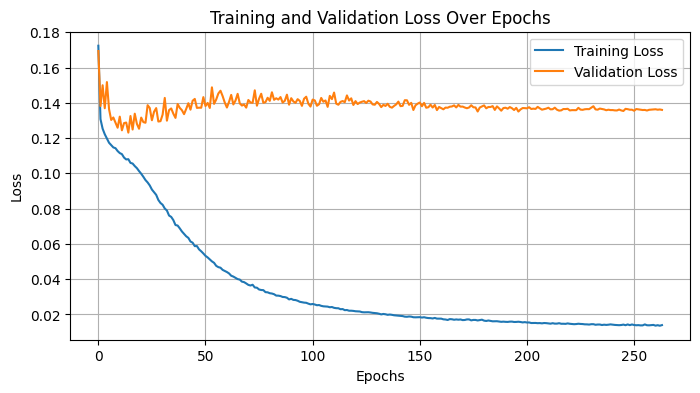

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


#### Apply the Model to CMIP6 Data to Downscale to GMFD Original Resolution
Now we take the coarse CMIP6 data and downscale it to the original GMFD resolution


In [12]:
# Load the model
from keras.models import load_model
#model = load_model('models/cnn_encoder_decoder.keras')

# Predict downscaled high-resolution data
predicted_high_res = model.predict(cmip6_train_reshaped)

742/742 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step


#### Post-process the Predictions

In [13]:
# Inverse transform the predictions to get the actual temperature values


# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values


# Back-transform the predictions and actual values
predicted_high_res_denorm = denormalize(predicted_high_res, cmip6_high_res_mean, cmip6_high_res_std)

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/unet/predicted_high_res_tas_unet_v03.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


#### Scenario data

In [14]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp245 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp245 = xr.open_zarr(cmip6_ssp245)
cmip6_sp245_high_res = cmip6_ssp245.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp245_norm = normalize(cmip6_sp245_high_res['tas'])
# Reshape data to add the channel dimension
cmip6_sp245_reshaped = cmip6_sp245_norm.values[..., np.newaxis]
cmip6_sp245_reshaped.shape

(31411, 42, 97, 1)

#### Perform the predictions on scenario data

In [15]:
# Load the model
from keras.models import load_model

#model_saved = load_model('models/unet_CNRM-ESM2-1.keras')
# Load your model with the custom loss function
model_saved = load_model(
    'models/unet_CNRM-ESM2-1.keras',
    custom_objects={'ClimateDownscalingLossJAX': ClimateDownscalingLossJAX}
)

# Predict downscaled high-resolution data
predicted_high_res = model_saved.predict(cmip6_sp245_reshaped)

# Get the mean and std from the training set for denormalization
cmip6_sp245_reshaped_mean = cmip6_sp245_high_res['tas'].mean().values
cmip6_sp245_reshaped_std = cmip6_sp245_high_res['tas'].std().values

# Back-transform function
def denormalize(data, mean, std):
    return (data * std) + mean
# Back-transform the predictions and actual values
predicted_high_res_denorm = denormalize(predicted_high_res, cmip6_sp245_reshaped_mean,cmip6_sp245_reshaped_std)


982/982 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step


In [17]:

predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp245_norm.values.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_norm.dims, coords=cmip6_sp245_norm.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/unet/predicted_high_res_tas_ssp245.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


In [ ]:
#Select the first time step
first_time_step = predicted_ds.isel(time=0).compute()  # Use .compute() if using Dask
first_time_step.plot()